# Ford GoBike / Lyft Bay Wheels
- This notebook is dedicated to data explanations of the Ford GoBike / Lyft Bay Wheels data
- Data was obtained from the [archives](https://s3.amazonaws.com/baywheels-data/index.html) linked to from the [System Data](https://www.fordgobike.com/system-data) page of the Lyft Bikes web site
- In other notebooks
    - Data was previously imported into a SQL Lite database
    - Data has been explored and some cleaning has been conducted, or areas of concern have been noted
    - Data has been augmented with extra features to allow easier explanatory data visualization
- The outcome of this notebook will go be an explanatory data analysis 
- This is then saved and refined into a final notebook dedicated to visualization using a slide show

# Main Findings
- During data exploration and the subsequent data exploration notebooks the most significant finding was a large variability in patronage of the Ford GoBike and Lyft Bay Wheels service
- This culminated in what looks like a drastic downturn in the usage for the final month of the data, March 2020
- The explanatory analysis and slide show presents this information in the initial part using trip counts analysis, and in the final geographical analysis
- Along the way the explanatory analysis presents significant data analysis of the main data points, so that a clear picture emerges of customer demographics
- It can be understood that the most important users are Subscribers, and that at the end of the available data they have deserted the service in large numbers

## Data exploration, cleaning and augmentation
- There are around 5.8 million rows in the data, which makes it difficult to handle on my PC with 16GB RAM
- I had to run the exploratory data analysis and augmentation with no other applications running 
- Therefore, I opened a working copy of the data from SQL, applied any fixes to it, then wrote it back into SQL
- To examine the data I made smaller Pandas dataframes of the specific data I was interested in, and learned from those 
- Data cleaning / fixing was applied to those smaller dataframes as a test, before being applied back to the original dataframe

## Explanatory data analysis approach
- Data will be retrieved from the SQL Lite database with targeted queries into Pandas dataframes
- Where possible, SQL will be used to aggregate the data
- Depending on the complexity of the task, explanatory visuals developed in this notebook may be transferred to a final notebook for development of the final slide show that explains the work

## Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as tick
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import PercentFormatter

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', -1)

In [3]:
import warnings
warnings.filterwarnings("ignore", 
    message="Using the countplot function without specifying `order` is likely to produce an incorrect plot.")
warnings.filterwarnings("ignore", 
    message="Using the pointplot function without specifying `order` is likely to produce an incorrect plot.")

In [4]:
import sqlite3

In [5]:
from sqlalchemy import MetaData
from sqlalchemy import create_engine
from sqlalchemy import Table, Column
from sqlalchemy import Integer, String, Float

In [6]:
# sns.set(font_scale=1.4)
# https://dfrieds.com/data-visualizations/how-format-large-tick-values.html

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K 
    and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [7]:
def load_df_from_sql(db_path='fordgobike.db', table_name='tripdata_fixed', test=False):
    if test:
        query = '''SELECT * FROM %s LIMIT 100''' % table_name
    else:    
        query = '''SELECT * FROM %s''' % table_name
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, con=conn)
    return df

In [8]:
def load_from_sql(query, db_path='fordgobike.db'):
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(query, con=conn)
    return df

In [9]:
def update_sql(query, db_path='fordgobike.db'):
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        conn.commit()
        cursor.close()

## Database and tables

In [10]:
engine = create_engine('sqlite:///fordgobike.db', echo=False)

In [11]:
metadata = MetaData(engine)
metadata.reflect(bind=engine)

In [12]:
def dump(sql, *multiparams, **params):
    print(sql.compile(dialect=engine.dialect))
    
## Look at table structures by constructing a `CREATE TABLE` query
print_engine = create_engine('sqlite:///fordgobike.db', strategy='mock', executor=dump)
metadata.create_all(print_engine, checkfirst=False)


CREATE TABLE tripdata (
	recid INTEGER NOT NULL, 
	rowindex INTEGER, 
	duration_sec INTEGER, 
	start_time TIMESTAMP, 
	end_time TIMESTAMP, 
	start_station_id INTEGER, 
	start_station_name TEXT, 
	start_station_latitude REAL, 
	start_station_longitude REAL, 
	end_station_id INTEGER, 
	end_station_name TEXT, 
	end_station_latitude REAL, 
	end_station_longitude REAL, 
	bike_id INTEGER, 
	user_type TEXT, 
	member_birth_year INTEGER, 
	member_gender TEXT, 
	bike_share_for_all_trip TEXT, 
	rental_access_method TEXT, 
	datasource TEXT, 
	PRIMARY KEY (recid)
)



CREATE TABLE tripdata_fixed (
	recid INTEGER, 
	rowindex INTEGER, 
	duration_hrs REAL, 
	duration_min REAL, 
	duration_sec INTEGER, 
	start_time TIMESTAMP, 
	end_time TIMESTAMP, 
	start_date TIMESTAMP, 
	start_yearmonth TEXT, 
	start_year INTEGER, 
	start_month INTEGER, 
	start_month_name TEXT, 
	start_day INTEGER, 
	start_day_name TEXT, 
	start_hour INTEGER, 
	end_date TIMESTAMP, 
	end_yearmonth TEXT, 
	end_year INTEGER, 
	end_month

## The SQL tables
#### The original data is in table `tripdata`,  fixed and enhanced is in table `tripdata_fixed`

### According to the System Data page the archives have the following structure
<br>
Each trip is anonymized and includes:

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

### Core data structure
- `duration_sec` - length of trip in seconds
- `start_time` - trip start datetime
- `end_time` - trip end datetime
- `start_station_id` - start station id
- `start_station_name` - start station name
- `start_station_latitude` - start station latitude
- `start_station_longitude` - start station longitude
- `end_station_id`  - end station id
- `end_station_name`  - end station name
- `end_station_latitude` - end station latitude
- `end_station_longitude` - end station longitude
- `bike_id` - bike id
- `user_type` - user type
- `member_birth_year` - year of member's birth
- `member_gender` - member's gender
- `bike_share_for_all_trip` - was 'bike share' used for all the trip
- `rental_access_method` - rental access method
<br><br>
- `member_birth_year`, `member_gender`, `bike_share_for_all_trip` and `rental_access_method` 
    - these were not used in all original data, but are now in common because the data is stored in one table

### Added columns in both tables
- `recid` unique database identifier was added for database performance purposes
- `datasource` - year or yearmonth of the original CSV file used
- `rowindex` - original index of row in source CSV file
    - `rowindex` and `datasource` have been added during data import to allow reconciliation with original data if needed

### Added columns in the fixed data
- `duration_hrs` - trip duration in hours
- `duration_min` - trip duration in minutes
- `start_date` - a date version of `start_time` to allow for easier aggregation 
- `start_yearmonth` - `start_time` year and month
- `start_year` - the year of the `start_time`
- `start_month` - the number of the `start_time` month (1 to 12)
- `start_month_name` - the name of the `start_time` month (January etc.)
- `start_day` - the number of the `start_time` day (1 to 31)
- `start_day_name` - the name of the `start_time` day (Monday etc.)
- `start_hour` - the number of the `start_time` hour (1 to 24)
- `end_date` - a date version of `end_time` to allow for easier aggregation
- `end_yearmonth` - `end_time` year and month
- `end_year` - the year of the `end_time`
- `end_month` - the number of the `end_time` month (1 to 12)
- `end_month_name` - the name of the `end_time` month (January etc.)
- `end_day` - the number of the `end_time` day (1 to 31)
- `end_day_name` - the name of the `end_time` day (Monday etc.)
- `end_hour` - the number of the `end_time` hour (1 to 24)
- `has_start_id` - boolean to indicate that a start station id exists (1=True, 0=False)
- `has_start_name` - boolean to indicate that a start station name exists (1=True, 0=False)
- `has_end_id` - boolean to indicate that a start station id exists (1=True, 0=False)
- `has_end_name` - boolean to indicate that a start station name exists (1=True, 0=False)
- `member_age` - member age, derived from `member_birth_year` but corrected where needed based on assumptions of data entry errors
- `age_group` - age groups to allow for easier aggregation of age - 18-25, 25-30, 30-35, 35-40, 40-45, 45-50, 50-55, 55-60, 60-70, 70+
- `age_grp_order` - integer to signify correct order of age groups
- `yearmonth` `start_time` year and month, but aligned with `datasource` where 1st of following month records are included
- `reccount` a value of 1 to allow for SQL sum of aggregated records

# Explanatory data analysis

## 1. Total Counts
- There are around 5.8 million records

In [13]:
%%time
query = '''SELECT COUNT(*) AS RecCount FROM tripdata_fixed'''
df_reccount = load_from_sql(query)

Wall time: 6.83 s


In [14]:
print('{:,}'.format(df_reccount.iloc[0]["RecCount"]))
del df_reccount

5,795,411


## 2. Long term usage patterns

In [15]:
query = '''SELECT substr(yearmonth, 1, 4) AS year_name,
yearmonth, 
start_month_name,
user_type,
SUM(reccount) AS trip_count 
FROM tripdata_fixed 
GROUP BY year_name, yearmonth, start_month_name, user_type 
ORDER BY year_name, yearmonth, start_month_name, user_type
'''

In [16]:
%%time
df_counts = load_from_sql(query)

Wall time: 2min 18s


In [17]:
startmonthvals = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                  'August', 'September', 'October', 'November', 'December']

pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    startmonthClass = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = startmonthvals)
    df_counts['start_month_name'] = df_counts.start_month_name.astype(
                                            startmonthClass)
else:
    df_counts['start_month_name'] =  df_counts.start_month_name.astype(
                                            'category', 
                                            ordered = True,
                                            categories = startmonthvals)

In [18]:
df_counts["user_type"] = df_counts.user_type.astype("category")

In [19]:
df_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   year_name         70 non-null     object  
 1   yearmonth         70 non-null     object  
 2   start_month_name  70 non-null     category
 3   user_type         70 non-null     category
 4   trip_count        70 non-null     int64   
dtypes: category(2), int64(1), object(2)
memory usage: 2.4+ KB


### Trips per month seasonal pattern
- the chart summarizes trips per month for 2018 and 2019
- there is decreased usage from November through February 
- maximum usage is in the months of July and October

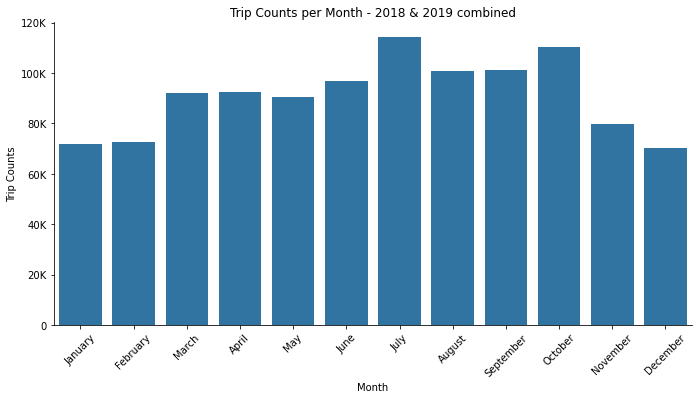

In [20]:
base_color = sns.color_palette()[0]
sns.catplot(data = df_counts.loc[df_counts.year_name.isin(['2018','2019'])], 
            x = 'start_month_name', 
            y = 'trip_count', kind="bar",
            color = base_color, 
            ci=None, 
            height=5, 
            aspect=2);

plt.xlabel('Month')
plt.ylabel('Trip Counts')
plt.title('Trip Counts per Month - 2018 & 2019 combined')
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

### Trips per month analysis
- The data stretches from June 2017 to March 2020
- The monthly figures show a gradual increase over the years
- Seasonal fluctuations occur 
    - the US fall to winter months of November and December show a decrease,
    - which begins increasing again in January and more so by March
- However, the 2019 year also has a dip around April to June, and a spike in July
- See an [Lyft Blog announcement](https://www.lyft.com/blog/posts/introducing-bay-wheels-new-bikes-and-a-new-name) and this [Verge](https://www.theverge.com/2019/6/11/18660048/lyft-gobike-bay-wheels-ebike-bikeshare-san-francisco) article in June 2019
    - they show "Ford GoBike" being re-branded as "Bay Wheels" with the introduction of e-bikes to the service 
    - this most likely explains July's spike as linked to the e-bike introduction
- But then an article in [San Francisco Chronicle](https://www.sfchronicle.com/business/article/Lyft-s-Bay-Wheels-to-resume-e-bike-rentals-in-SF-14821170.php) explains that the e-bikes were pulled after July due to brake and battery problems, and only re-introduced late in December 2019
- a [Bay Wheels announcement](https://medium.com/@baywheels/sf-ebike-pricing-details-1b97667f1e5a) on 20th December 2019 confirms that they also announced a pending price change along with the re-introduction of e-bikes
- The 2020 year shows a large spike from January to February - peaking from an average of around 200 thousand to around 400 thousand
- The March 2020 figures are back down to where they were in November 2019
- See articles in [Medium](https://medium.com/@baywheels/sf-ebike-pricing-details-1b97667f1e5a), [San Francisco Examiner](https://www.sfexaminer.com/news/i-canceled-my-membership-customer-backlash-after-lyft-hikes-bay-area-bikeshare-prices) and [Curbed](https://sf.curbed.com/2020/2/26/21154722/ebike-lyft-prices-uber-permit-cancel-san-francisco):
- a quote from the SF Examiner report: 
    - "The San Francisco Examiner also asked readers to react to the price changes via Twitter. Many said they would cancel their memberships in response to not only the price hikes, but the difficulty in navigating the pricing structure, which features a different per-minute fee structure, and different charges depending on your membership and where you ride."
        
- and from Curbed:
     - "Speaking of which, with the new changes happening at Lyft, what’s happening with the e-bike competition? Well, that’s the catch—there isn’t any competition. As the San Francisco Chronicle points out, it is probably not a coincidence that these changes are happening at the same time that Uber will lose its license to rent bikes in the city altogether on March 1. In hindsight, it’s surprising that the city relied so heavily on the same companies that it largely blames for generating auto woes in SF to be the key pillars of the e-bike revolution. At least there’s no changes to the price of renting ordinary non-electronic bikes, leaving the semi-luddites among us to pedal in peace—for now."
- and numerous exasperated [comments](https://medium.com/p/1b97667f1e5a/responses/show) like this from a [medium](https://medium.com/@baywheels/sf-ebike-pricing-details-1b97667f1e5a) article announcing the price changes...
    - "Doing a cost analysis w/ the new pricing just makes bay wheels no longer an appealing option for daily commuters compared to purchasing a personal e-bike/boosted board/electric scooter..
Assuming a 20 min one-way commute, that amounts to 6\\$/day for MEMBERS. If a person commutes 220–240 days a year give or take, that’s ~1400\\$ spend + the 150\\$ membership (enough for roughly 2 e-bikes). This is genuinely disappointing from Lyft (a company that has historically positioned itself as for the people vs Uber) and for the moment I will be cancelling my baywheels membership."

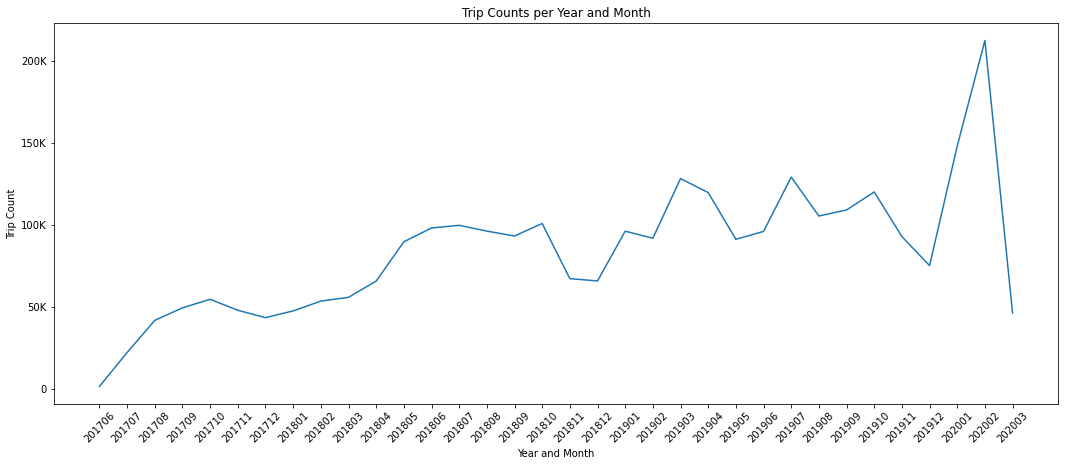

In [21]:
f = plt.figure(figsize=(18, 7))
ax = sns.lineplot(x="yearmonth", y="trip_count",
                  data=df_counts, ci=None)
plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('Trip Counts per Year and Month')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

### Trips per month user type analysis
- When user type type is examined it shows that most are subscribers, rather than casual customers
- Subscribers show more marked decreases in subscription levels over the October to December months followed by an increase from January to February
- In December 2019 and more emphatically in December 2020 casual riders increase while subscribers always decrease to their lowest point
- The rise in January to February 2020 followed by the drop in March 2020 is reflected in both user types
- However, the drop in March 2020 is most marked in the subscriber numbers - this accords with the SF Examiner report of subscriber reactions

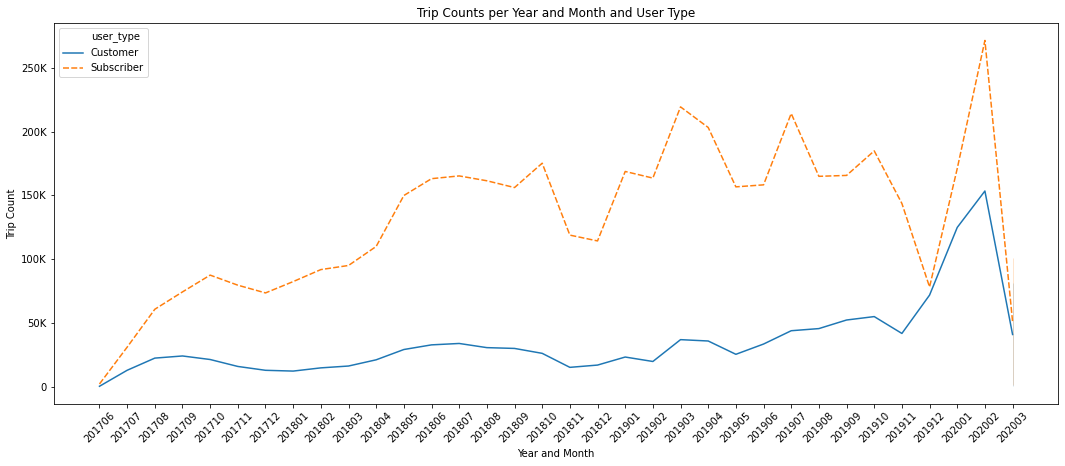

In [22]:
f = plt.figure(figsize=(18, 7))
ax = sns.lineplot(x="yearmonth", y="trip_count",
                  hue="user_type", 
                  style="user_type", 
                  data=df_counts)

plt.xlabel('Year and Month')
plt.ylabel('Trip Count')
plt.title('Trip Counts per Year and Month and User Type')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

### Trips detail per day over January to March 2020
- check if daily patterns suggest any special event to account for the February spike 

In [23]:
query = '''SELECT yearmonth, 
user_type,
start_date,
start_day,
start_day_name,
SUM(reccount) AS trip_count 
FROM tripdata_fixed 
WHERE yearmonth in ('202001','202002','202003')
GROUP BY yearmonth, user_type, start_date, start_day, start_day_name 
ORDER BY yearmonth, user_type, start_date, start_day, start_day_name
'''

In [24]:
%%time
df_daily_counts = load_from_sql(query)

Wall time: 2min 18s


In [25]:
weekdayvals = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

pd_ver = pd.__version__.split(".")
if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
    weekdayClass = pd.api.types.CategoricalDtype(ordered = True,
                                                 categories =weekdayvals)
    df_daily_counts['start_day_name'] = df_daily_counts.start_day_name.astype(
                                            weekdayClass)
else:
    df_daily_counts['start_day_name'] =  df_daily_counts.start_day_name.astype(
                                            'category', 
                                            ordered = True,
                                             categories = weekdayvals)

In [26]:
df_daily_counts['start_date'] = pd.to_datetime(df_daily_counts['start_date']).dt.date

In [27]:
df_daily_counts.head()

,yearmonth,user_type,start_date,start_day,start_day_name,trip_count
0,202001,Customer,2020-01-01,1,Wednesday,1457
1,202001,Customer,2020-01-02,2,Thursday,2954
2,202001,Customer,2020-01-03,3,Friday,3134
3,202001,Customer,2020-01-04,4,Saturday,2072
4,202001,Customer,2020-01-05,5,Sunday,1804


In [28]:
df_daily_counts.tail()

,yearmonth,user_type,start_date,start_day,start_day_name,trip_count
179,202003,Subscriber,2020-03-28,28,Saturday,1154
180,202003,Subscriber,2020-03-29,29,Sunday,1046
181,202003,Subscriber,2020-03-30,30,Monday,1280
182,202003,Subscriber,2020-03-31,31,Tuesday,1359
183,202003,Subscriber,2020-04-01,1,Wednesday,1376


### The patterns of usage are strongest on weekdays
- both subscribers and customers use bikes far more during the week, 
    - the usage for both is much higher in February 2020,
    - and the subscribers are also relatively much higher than customers in February
    - also in February, subscribers riding in the weekend exceeded event the customers during the week
- in March the numbers have declined dramatically, except for a spike in subscribers on Sunday

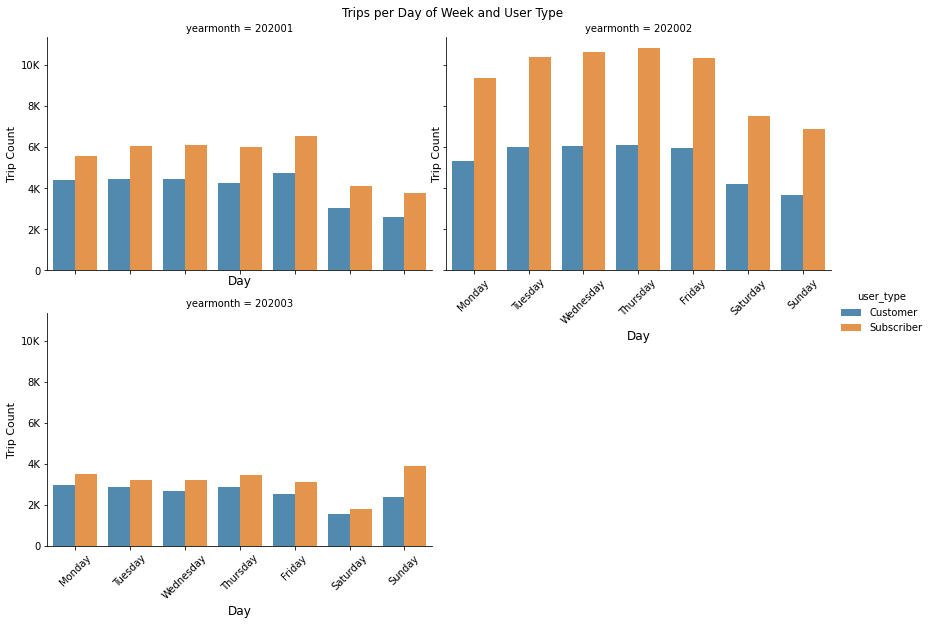

In [29]:
g = sns.catplot(x="start_day_name", 
                y="trip_count",
                hue="user_type",
                col="yearmonth",
                alpha=0.85,
                col_wrap=2,
                data=df_daily_counts, 
                ci=None,
                kind="bar",
                #legend_out=False,
                #legend=False,
                height=4, aspect=1.5)

#plt.legend(loc='upper right')

g.fig.suptitle('Trips per Day of Week and User Type', y=1.01)
for ax in g.axes.flatten():
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Trip Count', fontsize=11)
    ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
    
g.set_xticklabels(rotation=45)
plt.show();

### The daily patterns are very much higher for subscribers, for a period
- at the beginning of January subscribers are less that casual customers
- from around 15th January subscriber numbers grow to as much as twice as many as casual customers
- then drop off to be about the same, very much lower figure, after 1st March
- there is one slightly higher jump in subscriber trips on 1st March, but otherwise there is nothing distinctive about any single day
- the saw-tooth effect is because of the weekly usage pattern which drops off during the weekends

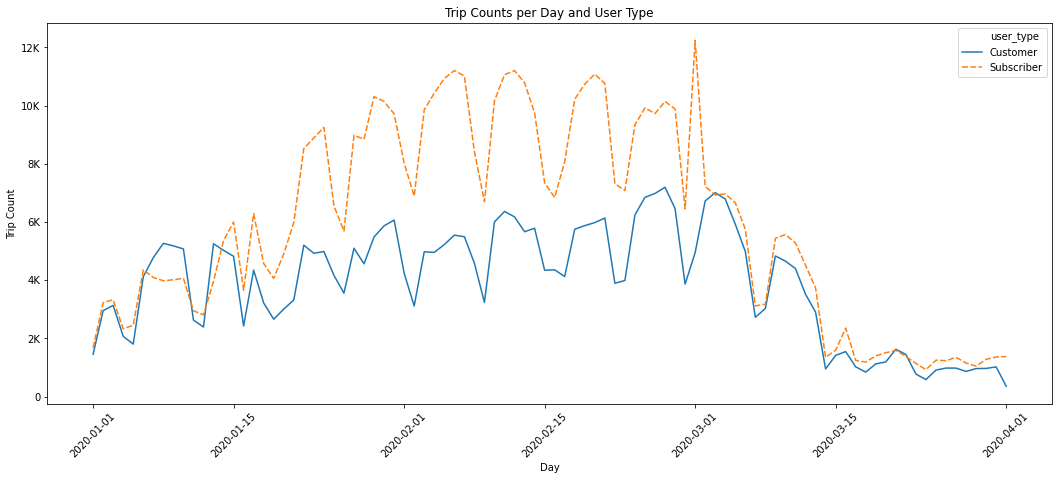

In [30]:
f = plt.figure(figsize=(18, 7))
ax = sns.lineplot(x="start_date", 
                  y="trip_count",
                  hue="user_type", 
                  style="user_type", 
                  data=df_daily_counts)
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Trip Count')
plt.title('Trip Counts per Day and User Type')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

### The final days of February going into March 2020
- the saw-tooth pattern reflects weekly usage 
- the uncharacteristic jump in subscriber trips on 1st March, which was a Sunday, could be a last round of rides on an expiring subscription
- the large jump of subscribers on this particular Sunday explains the increase in subscribers noted above in the weekly pattern for March
- after that numbers plummet for both type of user

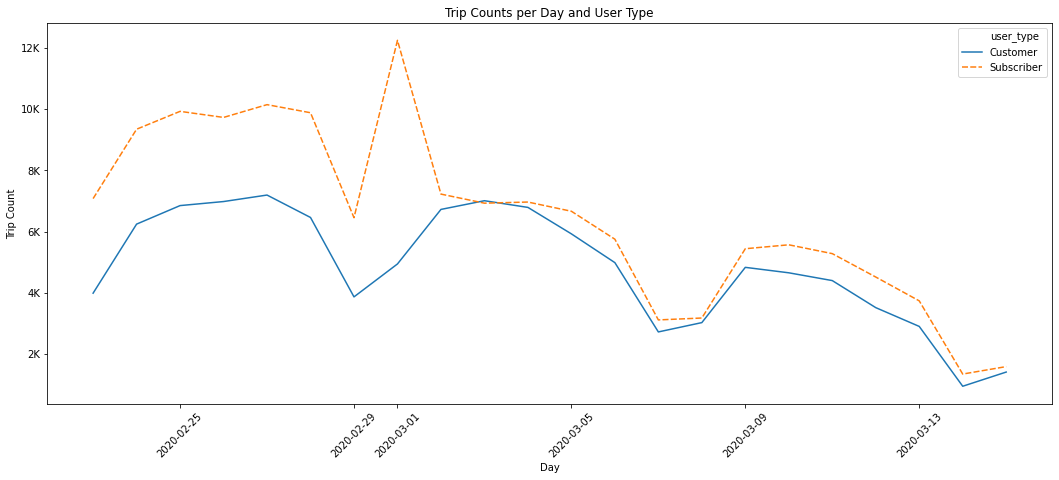

In [31]:
f = plt.figure(figsize=(18, 7))
ax = sns.lineplot(x="start_date", 
                  y="trip_count",
                  hue="user_type", 
                  style="user_type", 
                  data=df_daily_counts.loc[(df_daily_counts.start_date>=pd.Timestamp('2020-02-23'))
                                         & (df_daily_counts.start_date<=pd.Timestamp('2020-03-15'))])
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Trip Count')
plt.title('Trip Counts per Day and User Type')
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

##  Long term usage patterns conclusion
### Are Lyft "killing the golden goose" in San Francisco?
- the majority of users are subscribers
- subscribers are more clearly seasonal and allow their membership to lapse in winter months
- the sporadic availability of e-bikes is linked to fluctuating interest in the bikeshare program
- the re-introduction of e-bikes in later December 2019 was followed by a large increase of users, especially subscribers
- it is possible that the uncharacteristically high patronage that followed was due to people trying e-bikes before an impending price rise
- and, it is reasonable to infer that increased membership prices for e-bikes has led to a decreased patronage in March 2020
- the Lyft Financial [Quarterly Results](https://investor.lyft.com/financial-information/quarterly-results) don't reveal any detail in relation to specific operations, 
    - the results for this quarter ([Q1 2020](https://investor.lyft.com/news-releases/news-release-details/lyft-announces-first-quarter-results)) are 23% increased compared to Q1 2019
- interestingly though, the [Lyft stock chart](https://investor.lyft.com/stock-information) for 2019/20 shows similar trends in its share price to the SF numbers, 
    - including a marked downwards trend in March 2020, 
    - but this is over the entire company, not just the bikeshare program in SF


![stock_chard](images/lyft_stock_chart.PNG)

----

## 3. Trip duration analysis
- rounding trip duration to a tenth of an hour, or a hundredth of an hour if less than a tenth
- group by this summary figure
- calculate minutes from it, and hour and minute totals

In [32]:
query = '''WITH hour_recs AS (
SELECT yearmonth, 
user_type,
ifnull(bike_share_for_all_trip, 'Unknown') AS bike_share_for_all_trip,
ifnull(age_group, 'Unknown') AS age_group, 
ifnull(member_gender, 'Unknown') AS member_gender,
substr(yearmonth, 1, 4) AS year_name,
start_month_name,
start_day_name,
start_hour,
SUM(reccount) AS trip_count, 
case when duration_hrs < 0.1 then round(duration_hrs, 2) else round(duration_hrs, 1) end AS duration_hrs
FROM tripdata_fixed 
GROUP BY yearmonth, user_type, bike_share_for_all_trip,
         ifnull(age_group, 'Unknown'), 
         ifnull(member_gender, 'Unknown'),
         substr(yearmonth, 1, 4),
         start_month_name, start_day_name, start_hour, 
case when duration_hrs < 0.1 then round(duration_hrs, 2) else round(duration_hrs, 1) end
)
SELECT hour_recs.* 
      ,round(duration_hrs * 60) AS  duration_min
      ,round(duration_hrs * trip_count, 2) AS total_hrs
      ,round(duration_hrs * 60 * trip_count, 2) AS total_min
FROM hour_recs
ORDER BY 1,2,3,4,5,6,7,8,9,11
'''

In [33]:
%%time
df_duration_summary = load_from_sql(query)

Wall time: 2min 52s


In [34]:
len(df_duration_summary)

864154

In [35]:
df_duration_summary.bike_share_for_all_trip.value_counts()

No         546826
Unknown    175309
Yes        142019
Name: bike_share_for_all_trip, dtype: int64

- unaggregated data using minutes to test distributions and specific trip information

In [36]:
query = '''SELECT yearmonth, 
user_type,
ifnull(bike_share_for_all_trip, 'Unknown') AS bike_share_for_all_trip,
member_age,
ifnull(age_group, 'Unknown') AS age_group, 
ifnull(member_gender, 'Unknown') AS member_gender,
start_month_name,
start_day_name,
start_time,
end_time,
duration_min,
reccount AS trip_count 
FROM tripdata_fixed 
ORDER BY 1,2,3,4,5,6,7,8
'''

In [37]:
%%time
df_minutes = load_from_sql(query)

Wall time: 1min 18s


In [38]:
len(df_minutes)

5795411

In [39]:
df_duration_summary["start_hour_name"] = df_duration_summary.start_hour.apply(
                                                    lambda x: ('0' if x < 10 else '') + str(x))

In [40]:
df_duration_summary["day_type"] = df_duration_summary["start_day_name"].apply(lambda x: "Weekend" 
                                                                        if x in ("Saturday","Sunday") else "Workday")

In [41]:
df_minutes["day_type"] = df_minutes["start_day_name"].apply(lambda x: "Weekend" if x in ("Saturday","Sunday") else "Workday")

In [42]:
df_minutes["start_time"] = pd.to_datetime(df_minutes["start_time"])
df_minutes["end_time"] = pd.to_datetime(df_minutes["end_time"])

In [43]:
df_minutes["duration_min"] = round(df_minutes["duration_min"],2)

In [44]:
ordinal_var_dict = {'start_month_name': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                         'August', 'September', 'October', 'November', 'December'],
                    'start_day_name': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                    'start_hour_name': ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', 
                                         '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
                    'day_type': ['Workday', 'Weekend'],
                    'member_gender': ['Male','Female','Other','Unknown'],
                    'age_group': ['18-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','60-70','70+','Unknown'],
                    'bike_share_for_all_trip': ['No','Yes','Unknown']
                   }

In [45]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)
for var in ordinal_var_dict:
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        df_duration_summary[var] = df_duration_summary[var].astype(ordered_var)
    else:
        df_duration_summary[var] = df_duration_summary[var].astype('category', ordered = True,
                                                             categories = ordinal_var_dict[var])

In [46]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)
for var in (var for var in ordinal_var_dict if var != 'start_hour_name'):
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        df_minutes[var] = df_minutes[var].astype(ordered_var)
    else:
        df_minutes[var] = df_minutes[var].astype('category', ordered = True,
                                                             categories = ordinal_var_dict[var])        

In [47]:
df_duration_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864154 entries, 0 to 864153
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   yearmonth                864154 non-null  object  
 1   user_type                864154 non-null  object  
 2   bike_share_for_all_trip  864154 non-null  category
 3   age_group                864154 non-null  category
 4   member_gender            864154 non-null  category
 5   year_name                864154 non-null  object  
 6   start_month_name         864154 non-null  category
 7   start_day_name           864154 non-null  category
 8   start_hour               864154 non-null  int64   
 9   trip_count               864154 non-null  int64   
 10  duration_hrs             864154 non-null  float64 
 11  duration_min             864154 non-null  float64 
 12  total_hrs                864154 non-null  float64 
 13  total_min                864154 non-null  fl

In [48]:
df_duration_summary.head()

,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,year_name,start_month_name,start_day_name,start_hour,trip_count,duration_hrs,duration_min,total_hrs,total_min,start_hour_name,day_type
0,201706,Customer,Unknown,18-25,Female,2017,June,Friday,10,1,0.20,12.00,0.20,12.00,10,Workday
1,201706,Customer,Unknown,18-25,Female,2017,June,Friday,15,1,0.40,24.00,0.40,24.00,15,Workday
2,201706,Customer,Unknown,18-25,Female,2017,June,Friday,17,1,0.30,18.00,0.30,18.00,17,Workday
3,201706,Customer,Unknown,18-25,Female,2017,June,Thursday,18,1,0.20,12.00,0.20,12.00,18,Workday
4,201706,Customer,Unknown,18-25,Female,2017,June,Thursday,18,1,0.30,18.00,0.30,18.00,18,Workday


In [49]:
df_duration_summary.loc[df_duration_summary.trip_count > 1].head()

,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,year_name,start_month_name,start_day_name,start_hour,trip_count,duration_hrs,duration_min,total_hrs,total_min,start_hour_name,day_type
8,201706,Customer,Unknown,18-25,Male,2017,June,Friday,9,2,0.20,12.00,0.40,24.00,09,Workday
11,201706,Customer,Unknown,18-25,Male,2017,June,Friday,16,2,0.20,12.00,0.40,24.00,16,Workday
27,201706,Customer,Unknown,25-30,Female,2017,June,Thursday,10,2,0.30,18.00,0.60,36.00,10,Workday
43,201706,Customer,Unknown,25-30,Male,2017,June,Thursday,12,2,0.40,24.00,0.80,48.00,12,Workday
47,201706,Customer,Unknown,25-30,Male,2017,June,Thursday,18,2,1.10,66.00,2.20,132.00,18,Workday


In [50]:
df_duration_summary.tail()

,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,year_name,start_month_name,start_day_name,start_hour,trip_count,duration_hrs,duration_min,total_hrs,total_min,start_hour_name,day_type
864149,202003,Subscriber,Unknown,Unknown,Unknown,2020,March,Wednesday,23,15,0.30,18.00,4.50,270.00,23,Workday
864150,202003,Subscriber,Unknown,Unknown,Unknown,2020,March,Wednesday,23,4,0.40,24.00,1.60,96.00,23,Workday
864151,202003,Subscriber,Unknown,Unknown,Unknown,2020,March,Wednesday,23,2,0.60,36.00,1.20,72.00,23,Workday
864152,202003,Subscriber,Unknown,Unknown,Unknown,2020,March,Wednesday,23,1,1.30,78.00,1.30,78.00,23,Workday
864153,202003,Subscriber,Unknown,Unknown,Unknown,2020,March,Wednesday,23,1,1.60,96.00,1.60,96.00,23,Workday


In [51]:
df_minutes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5795411 entries, 0 to 5795410
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   yearmonth                object        
 1   user_type                object        
 2   bike_share_for_all_trip  object        
 3   member_age               float64       
 4   age_group                category      
 5   member_gender            category      
 6   start_month_name         category      
 7   start_day_name           category      
 8   start_time               datetime64[ns]
 9   end_time                 datetime64[ns]
 10  duration_min             float64       
 11  trip_count               int64         
 12  day_type                 category      
dtypes: category(5), datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 381.4+ MB


In [52]:
df_minutes.head()

,yearmonth,user_type,bike_share_for_all_trip,member_age,age_group,member_gender,start_month_name,start_day_name,start_time,end_time,duration_min,trip_count,day_type
0,201706,Customer,None,nan,Unknown,Unknown,June,Friday,2017-06-30 21:06:41.792,2017-06-30 23:27:58.016,141.27,1,Workday
1,201706,Customer,None,nan,Unknown,Unknown,June,Friday,2017-06-30 21:06:33.129,2017-06-30 23:27:55.315,141.37,1,Workday
2,201706,Customer,None,nan,Unknown,Unknown,June,Friday,2017-06-30 23:06:06.870,2017-06-30 23:16:49.541,10.70,1,Workday
3,201706,Customer,None,nan,Unknown,Unknown,June,Friday,2017-06-30 22:08:21.248,2017-06-30 22:22:03.791,13.70,1,Workday
4,201706,Customer,None,nan,Unknown,Unknown,June,Friday,2017-06-30 21:09:07.131,2017-06-30 21:54:37.288,45.50,1,Workday


### Distribution of trip frequencies per hour of day
- the plots show overall frequencies for all usage, per hour of the day 
- there are two peaks in usage pattern at the times people typically commute to and from work
- this suggests that commuting is a major motivation for hiring the bikes
- people are still riding the past 11 p.m. (23) but there are very few after that until a renewed uptake starting at 5 a.m.

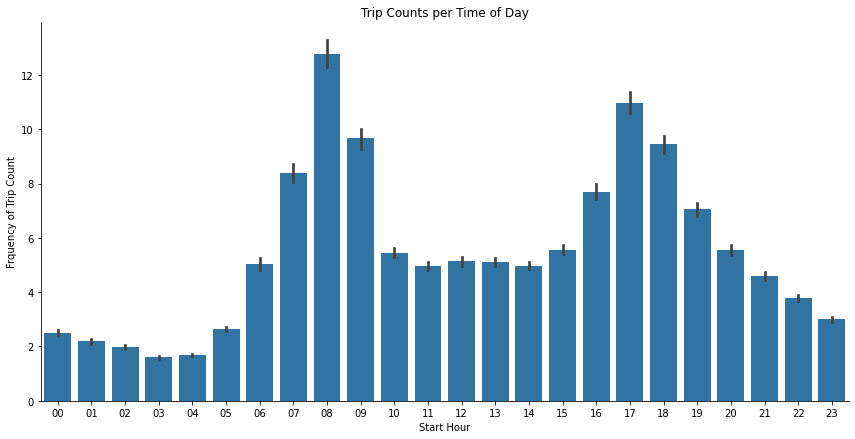

In [53]:
base_color = sns.color_palette()[0]
sns.catplot(data = df_duration_summary, x = 'start_hour_name', y = 'trip_count', kind="bar",
                color = base_color, height=6, aspect=2);

plt.xlabel('Start Hour')
plt.ylabel('Frquency of Trip Count')
plt.title('Trip Counts per Time of Day')
plt.show();

In [54]:
df_duration_summary.groupby('start_hour_name').trip_count.agg('sum') 

start_hour_name
00     33676
01     20390
02     13246
03      6819
04      8491
05     30812
06    116170
07    316543
08    628934
09    488104
10    260218
11    249393
12    279192
13    274020
14    263738
15    303924
16    451306
17    677293
18    527811
19    326251
20    209844
21    148804
22    100392
23     60040
Name: trip_count, dtype: int64

In [55]:
pd.options.display.float_format = '{:.5f}'.format

In [56]:
df_duration_summary.trip_count.sum()

5795411

In [57]:
round(df_duration_summary.loc[df_duration_summary.start_hour == 23].trip_count.sum() / df_duration_summary.trip_count.sum(), 4)

0.0104

In [58]:
summary_hrs = pd.DataFrame(list(zip(
        ordinal_var_dict['start_hour_name'],
        df_duration_summary.groupby('start_hour_name').trip_count.agg('sum'),
        round(df_duration_summary.groupby('start_hour_name').trip_count.agg('sum') / df_duration_summary.trip_count.sum(),4))
                               ),
                          )

In [59]:
summary_hrs.columns=["start_hour_name","trip_count", "frequency"]

In [60]:
summary_hrs

,start_hour_name,trip_count,frequency
0,00,33676,0.01
1,01,20390,0.00
2,02,13246,0.00
3,03,6819,0.00
4,04,8491,0.00
5,05,30812,0.01
6,06,116170,0.02
7,07,316543,0.05
8,08,628934,0.11
9,09,488104,0.08


In [61]:
summary_hrs.frequency.sum()

1.0

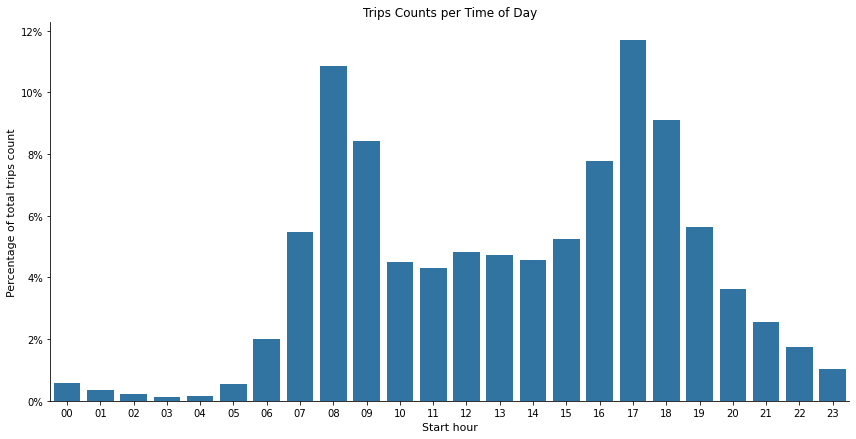

In [62]:
base_color = sns.color_palette()[0]
sns.catplot(data = summary_hrs, x = 'start_hour_name', y = 'frequency', kind="bar",
                color = base_color, height=6, aspect=2);
plt.xlabel('Start hour', fontsize=11)
plt.ylabel('Percentage of total trips count', fontsize=11)
plt.title('Trips Counts per Time of Day', fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.show();

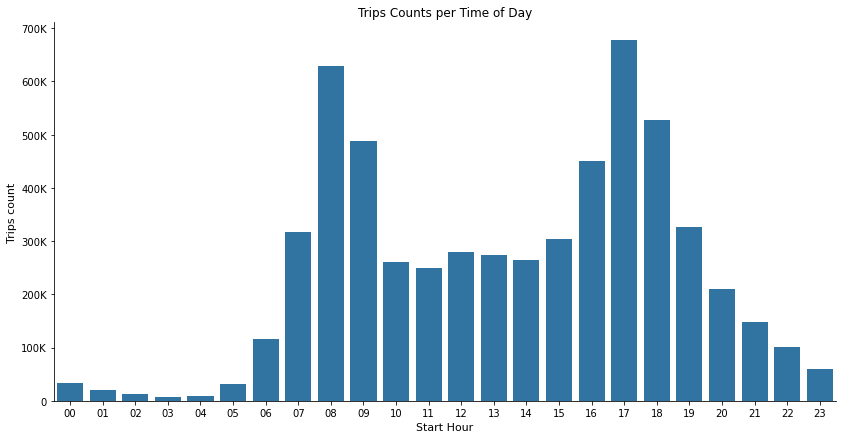

In [63]:
base_color = sns.color_palette()[0]
sns.catplot(data = summary_hrs, x = 'start_hour_name', y = 'trip_count', kind="bar",
                color = base_color, height=6, aspect=2);
plt.xlabel('Start Hour', fontsize=11)
plt.ylabel('Trips count', fontsize=11)
plt.title('Trips Counts per Time of Day', fontsize=12)

# ylimit = plt.gca().axes.get_ylim()[1]  # df_duration_summary.trip_count.sum()
# print(ylimit)  # 711157.65

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

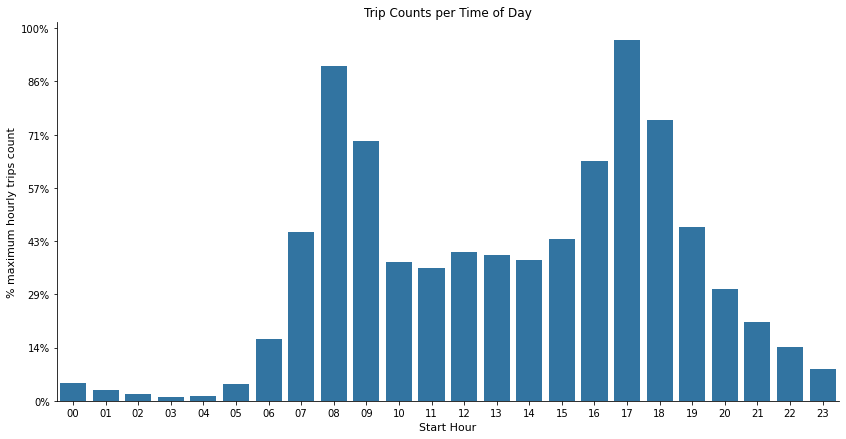

In [64]:
base_color = sns.color_palette()[0]
sns.catplot(data = summary_hrs, x = 'start_hour_name', y = 'trip_count', kind="bar",
                color = base_color, height=6, aspect=2);
plt.xlabel('Start Hour', fontsize=11)
plt.ylabel('% maximum hourly trips count', fontsize=11)
plt.title('Trip Counts per Time of Day', fontsize=12)

#perc_fmt = plt.gca().axes.get_ylim()[1]  # df_duration_summary.trip_count.sum()
#print(perc_fmt)  # 711157.65
perc_fmt = 700000 # plt.gca().axes.get_ylim()[1]  # df_duration_summary.trip_count.sum()

plt.gca().yaxis.set_major_formatter(PercentFormatter(perc_fmt
                                                    , decimals=0
                                                    ))
plt.show();

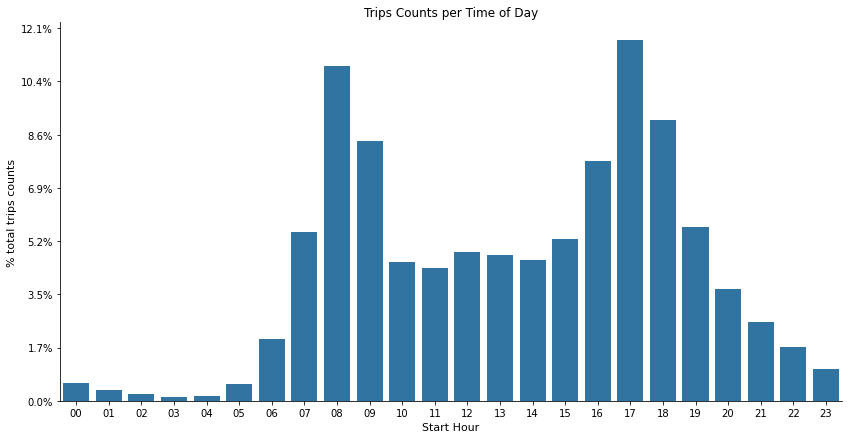

In [65]:
base_color = sns.color_palette()[0]
sns.catplot(data = summary_hrs, x = 'start_hour_name', y = 'trip_count', kind="bar",
                color = base_color, height=6, aspect=2);
plt.xlabel('Start Hour', fontsize=11)
plt.ylabel('% total trips counts', fontsize=11)
plt.title('Trips Counts per Time of Day', fontsize=12)

perc_fmt = df_duration_summary.trip_count.sum()
#print(perc_fmt) # 5795411

plt.gca().yaxis.set_major_formatter(PercentFormatter(perc_fmt
                                                    , decimals=1
                                                    ))
perc_fmt
plt.show();

### Distribution of "Bike Share for All Trip" frequencies per hour of day
- the plot shows overall frequencies for 'Bike Share for All Trip' usage only, per hour of the day 
- the numbers per hour increase steadily from 5 a.m. to a peak at 5 p.m. then drop off more quickly to 11 p.m.
- the pattern suggests people who are increasingly getting out for a bike ride as the day goes on, and not with consideration to a morning commute   
- the [Bike Share for All](https://www.lyft.com/bikes/bay-wheels/bike-share-for-all) web page says it is 
    -  affordable, accessible, and fun transportation option for everyone, and
    - Bay Area residents who qualify for CalFresh, SFMTA Lifeline Pass, or PG&E CARE utility discount are eligible to join our Bike Share for All program for $5 for the first year


In [66]:
summary_bike_share_hrs = pd.DataFrame(list(zip(
        ordinal_var_dict['start_hour_name'],
        df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].\
            groupby('start_hour_name').trip_count.agg('sum'),
            round(df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].\
                  groupby('start_hour_name').\
                  trip_count.agg('sum') / \
                  df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].trip_count.sum(),4))
                               ),
                          )

In [67]:
summary_bike_share_hrs.columns=["start_hour_name","trip_count", "frequency"]

In [68]:
summary_bike_share_hrs.frequency.sum()

0.9997

In [69]:
summary_bike_share_hrs

,start_hour_name,trip_count,frequency
0,00,4302,0.01
1,01,3486,0.01
2,02,2498,0.01
3,03,1212,0.00
4,04,1048,0.00
5,05,2905,0.01
6,06,5244,0.02
7,07,10787,0.03
8,08,16531,0.05
9,09,18130,0.05


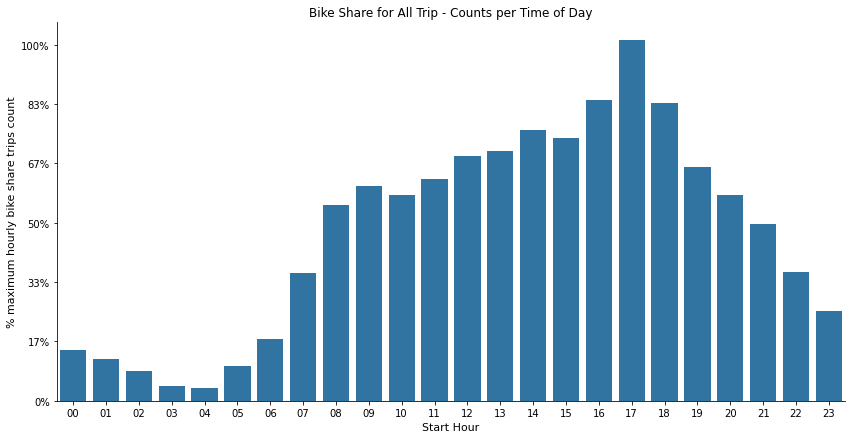

In [70]:
base_color = sns.color_palette()[0]
sns.catplot(data = summary_bike_share_hrs, x = 'start_hour_name', y = 'trip_count', kind="bar",
                color = base_color, height=6, aspect=2);
plt.xlabel('Start Hour', fontsize=11)
plt.ylabel('% maximum hourly bike share trips count', fontsize=11)
plt.title('Bike Share for All Trip - Counts per Time of Day', fontsize=12)

# perc_fmt = plt.gca().axes.get_ylim()[1]  # df_duration_summary.trip_count.sum()
# print(perc_fmt)  # 31888.5
perc_fmt = 30000 # plt.gca().axes.get_ylim()[1]  # df_duration_summary.trip_count.sum()

plt.gca().yaxis.set_major_formatter(PercentFormatter(perc_fmt
                                                    , decimals=0
                                                    ))
plt.show();

### Distribution of trip frequencies per hour of day of week
- the plot shows relative counts for all usage, per hour of the day and day of the week
- the daily commuting patterns exists only on week days, 
- on weekends there is a gradual increase from 8am, with maximums between midday and 5pm, then trailing off to the day's end

In [71]:
pd.options.display.float_format = '{:.5f}'.format

In [72]:
summary_days = pd.DataFrame(
        df_duration_summary.groupby(['start_day_name','start_hour_name']).trip_count.agg('sum')
).reset_index()

In [73]:
summary_days["day_type"] = summary_days["start_day_name"].apply(lambda x: "Weekend" 
                                        if x in ("Saturday","Sunday") else "Workday")
summary_days = summary_days[["start_day_name","day_type","start_hour_name","trip_count"]]

In [74]:
summary_bike_share_days = pd.DataFrame(
        df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].\
               groupby(['start_day_name','start_hour_name']).trip_count.agg('sum')
               ).reset_index()

In [75]:
summary_bike_share_days["day_type"] = summary_bike_share_days["start_day_name"].apply(lambda x: "Weekend" 
                                        if x in ("Saturday","Sunday") else "Workday")
summary_bike_share_days = summary_bike_share_days[["start_day_name","day_type","start_hour_name","trip_count"]]

In [76]:
summary_days.head()

,start_day_name,day_type,start_hour_name,trip_count
0,Monday,Workday,00,3095
1,Monday,Workday,01,1700
2,Monday,Workday,02,1246
3,Monday,Workday,03,731
4,Monday,Workday,04,1333


In [77]:
def day_freq(x, sumdf=summary_days):
    return round(x.trip_count / sumdf.loc[sumdf.start_day_name == x.start_day_name]["trip_count"].sum(), 5)

In [78]:
def tot_freq(x, sumdf=summary_days):
    return round(x.trip_count / sumdf.trip_count.sum(), 5)

In [79]:
summary_days["day_frequency"] = summary_days.apply(lambda x: day_freq(x), axis=1)
summary_bike_share_days["day_frequency"] = \
    summary_bike_share_days.apply(lambda x: day_freq(x, summary_bike_share_days), axis=1)

In [80]:
summary_days["total_frequency"] = summary_days.apply(lambda x: tot_freq(x), axis=1)
summary_bike_share_days["total_frequency"] = \
    summary_bike_share_days.apply(lambda x: tot_freq(x, summary_bike_share_days), axis=1)

In [81]:
summary_days.head()

,start_day_name,day_type,start_hour_name,trip_count,day_frequency,total_frequency
0,Monday,Workday,00,3095,0.00343,0.00053
1,Monday,Workday,01,1700,0.00188,0.00029
2,Monday,Workday,02,1246,0.00138,0.00021
3,Monday,Workday,03,731,0.00081,0.00013
4,Monday,Workday,04,1333,0.00148,0.00023


In [82]:
summary_bike_share_days.head()

,start_day_name,day_type,start_hour_name,trip_count,day_frequency,total_frequency
0,Monday,Workday,00,551,0.01106,0.00162
1,Monday,Workday,01,368,0.00739,0.00108
2,Monday,Workday,02,340,0.00683,0.00100
3,Monday,Workday,03,158,0.00317,0.00046
4,Monday,Workday,04,130,0.00261,0.00038


In [83]:
summary_days.groupby('start_day_name').day_frequency.agg('sum')

start_day_name
Monday      1.00000
Tuesday     1.00000
Wednesday   1.00000
Thursday    1.00002
Friday      1.00001
Saturday    1.00000
Sunday      1.00001
Name: day_frequency, dtype: float64

In [84]:
summary_bike_share_days.groupby('start_day_name').day_frequency.agg('sum')

start_day_name
Monday      0.99999
Tuesday     1.00001
Wednesday   1.00000
Thursday    0.99999
Friday      1.00001
Saturday    1.00003
Sunday      1.00002
Name: day_frequency, dtype: float64

In [85]:
summary_days.total_frequency.sum()

1.0

In [86]:
summary_bike_share_days.total_frequency.sum()

0.99996

#### Trips per Time and Day of Week, Counts

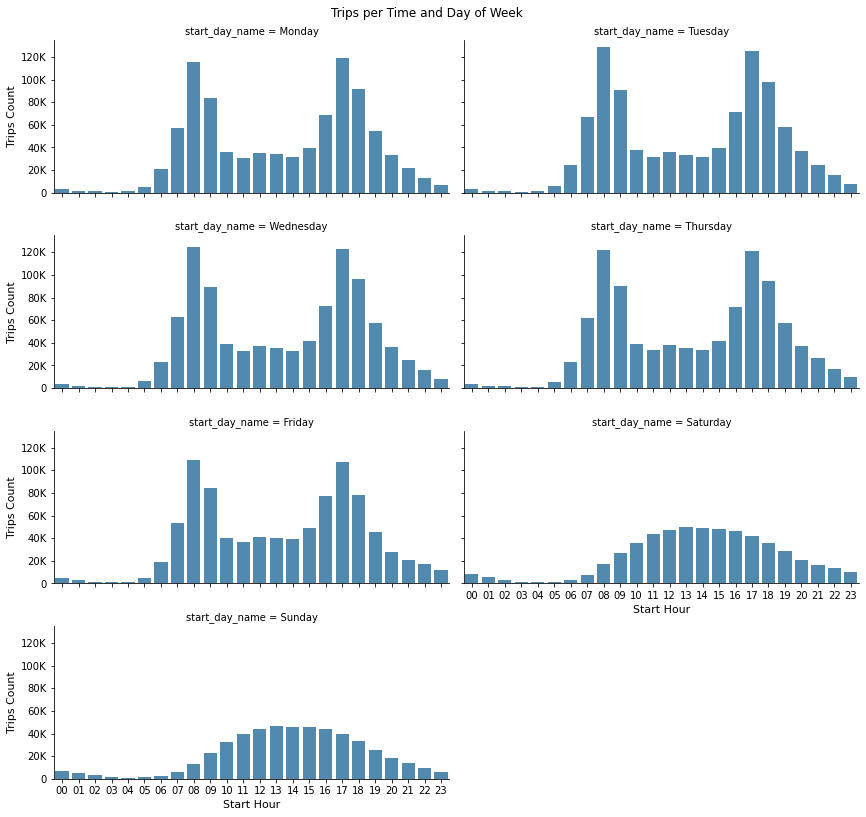

In [87]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="trip_count",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start Hour', fontsize=11)
    if i % 2 == 0:
        ax.set_ylabel('Trips Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))

plt.show();

#### Trips per Time and Day of Week, % max hourly count

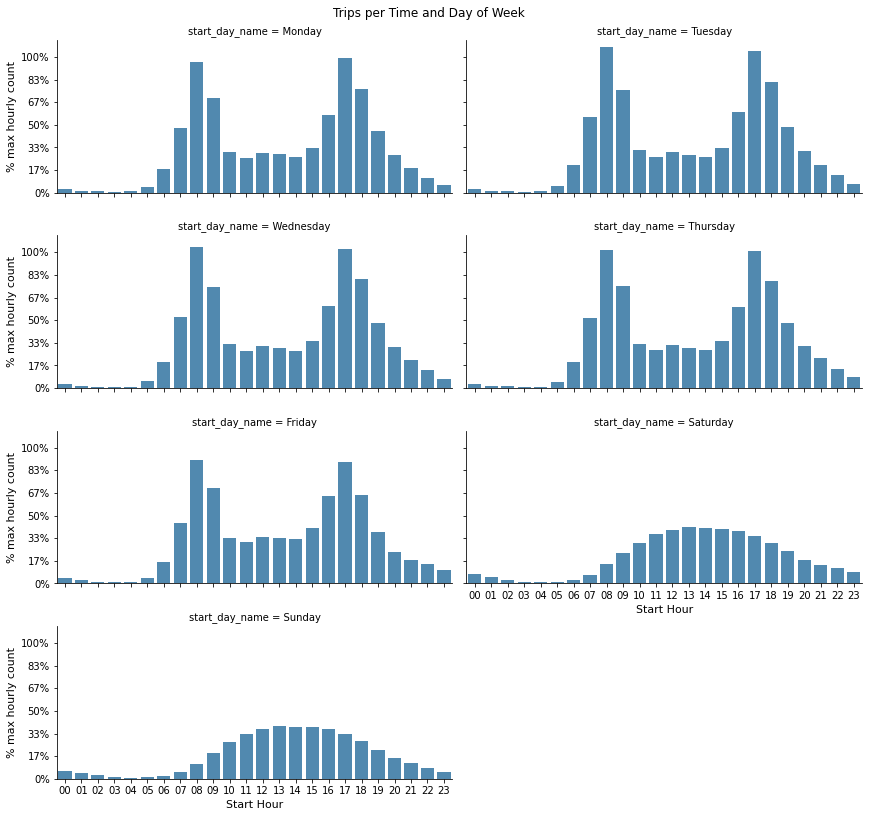

In [88]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="trip_count",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start Hour', fontsize=11)
    if i % 2 == 0:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(120000, decimals=0))
        ax.set_ylabel('% max hourly count', fontsize=11)

plt.show();

#### Trips per Time and Day of Week, % day trips count

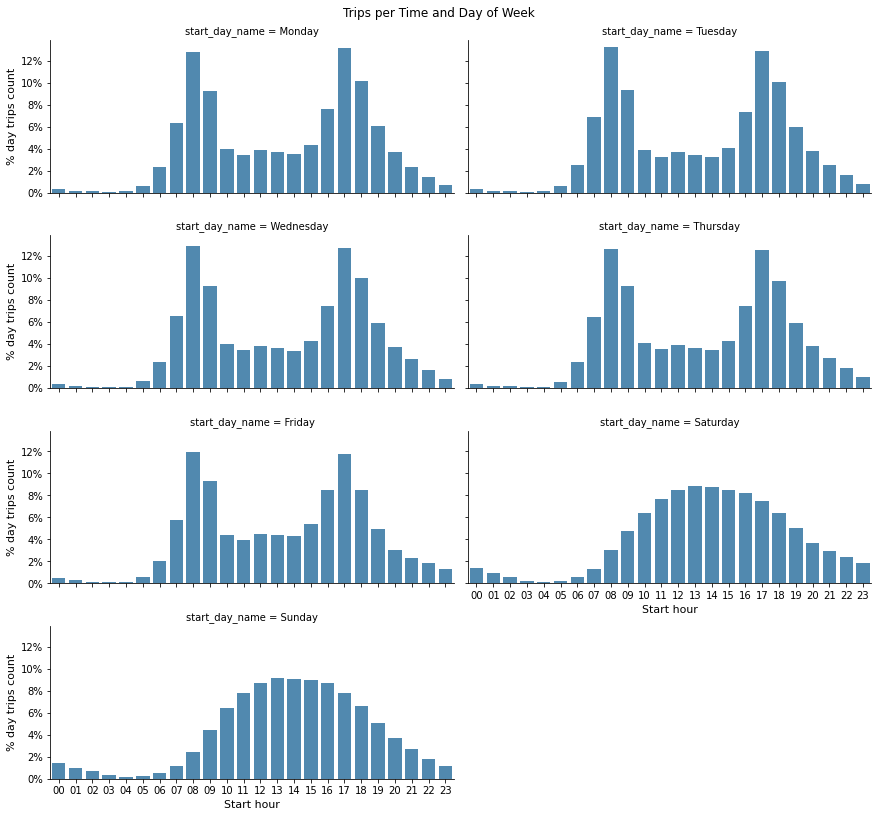

In [89]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="day_frequency",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start hour', fontsize=11)
    if i % 2 == 0:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
        ax.set_ylabel('% day trips count', fontsize=11)

plt.show();

#### Trips per Time and Day of Week, % total trips count

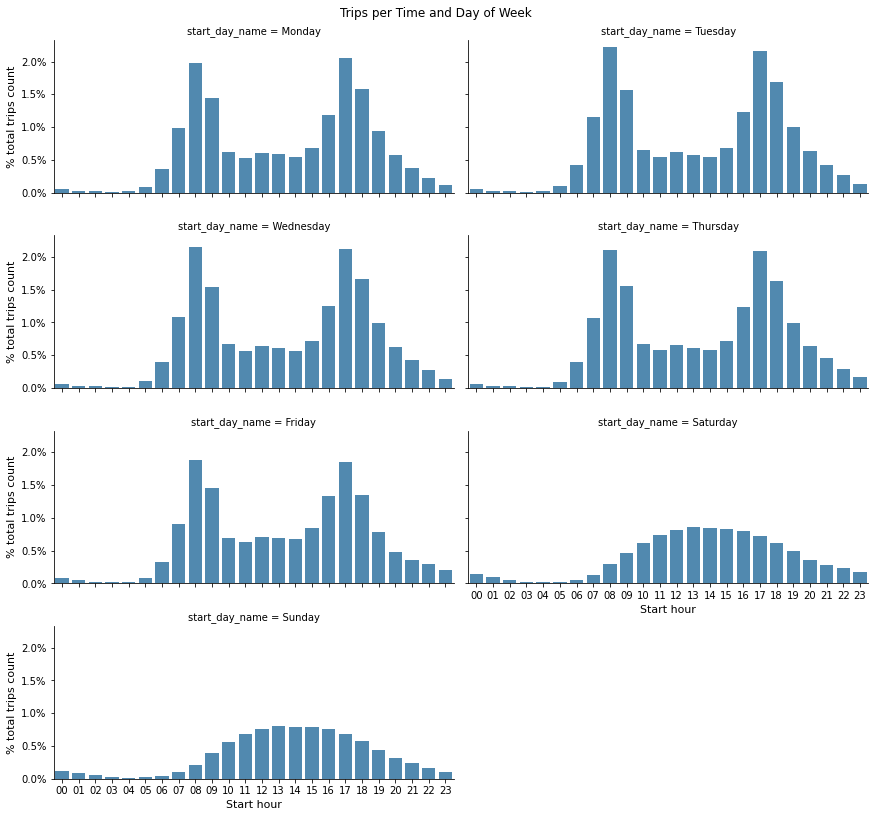

In [90]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="total_frequency",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start hour', fontsize=11)
    if i % 2 == 0:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
        ax.set_ylabel('% total trips count', fontsize=11)

plt.show();

#### Bike Share Trips per Time and Day of Week, % day trips count

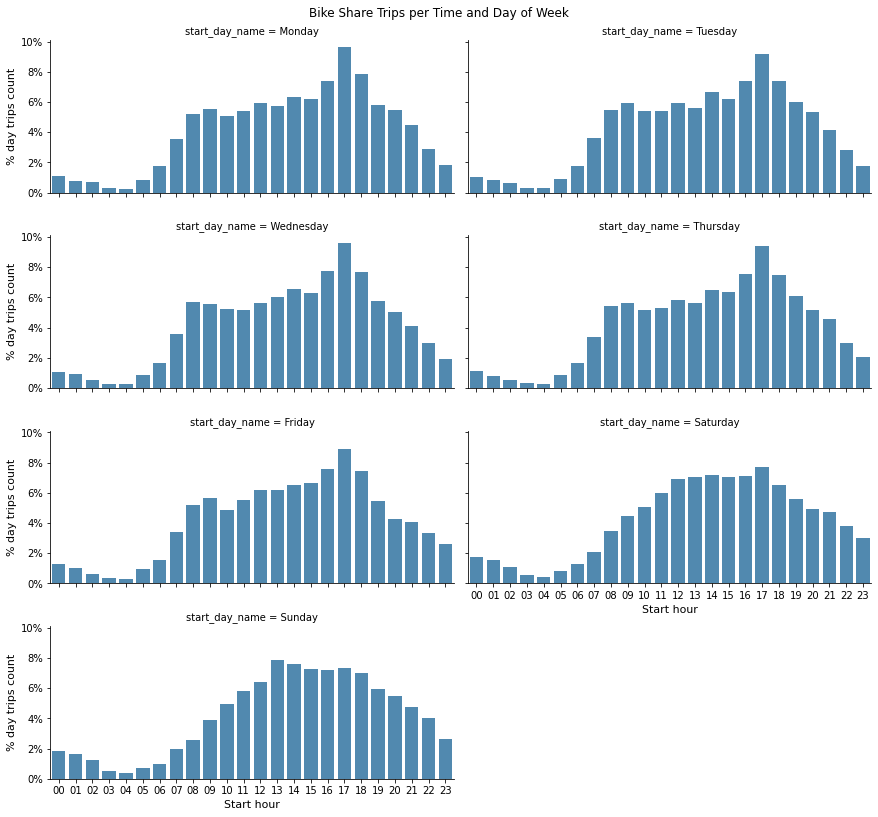

In [91]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="day_frequency",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_bike_share_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Bike Share Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start hour', fontsize=11)
    if i % 2 == 0:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
        ax.set_ylabel('% day trips count', fontsize=11)

plt.show();

#### Bike Share Trips per Time and Day of Week, % total trips count

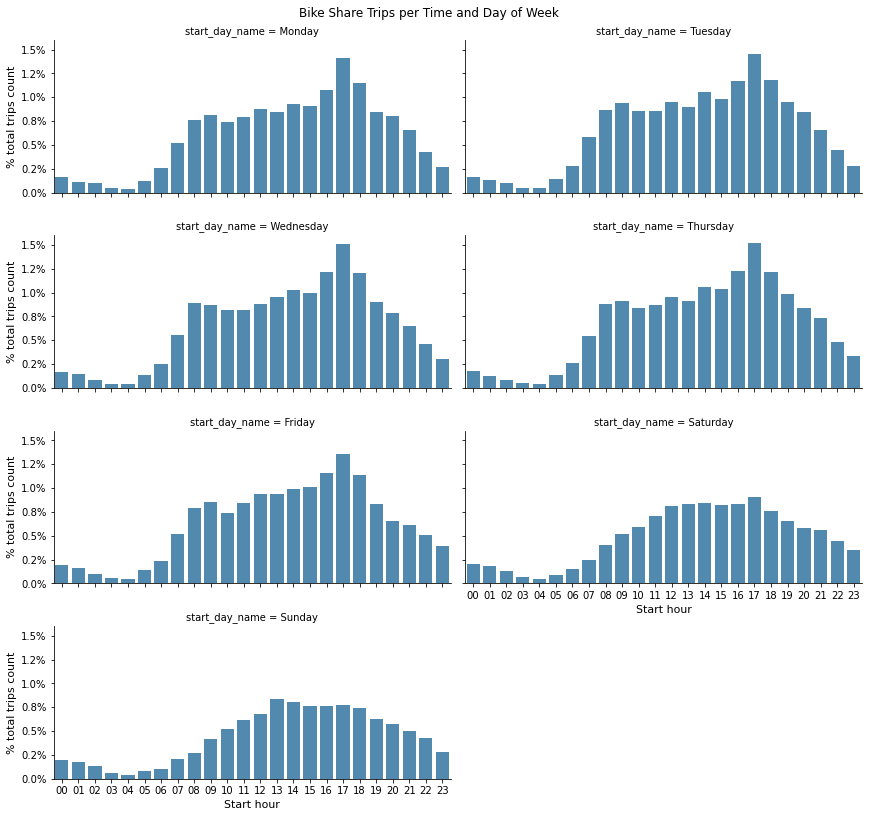

In [92]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="start_hour_name", 
                y="total_frequency",
                col="start_day_name",
                alpha=0.85,
                col_wrap=2,
                data=summary_bike_share_days, 
                ci=None,
                kind="bar",
                color = base_color,
                height=2.8, aspect=2.2)

g.fig.suptitle('Bike Share Trips per Time and Day of Week', y=1.01, fontsize=12)

for (i, ax) in enumerate(g.axes.flatten()):
    if i >= 5:
        ax.set_xlabel('Start hour', fontsize=11)
    if i % 2 == 0:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
        ax.set_ylabel('% total trips count', fontsize=11)

plt.show();

In [93]:
subscriber_days = pd.DataFrame(
        df_duration_summary.loc[df_duration_summary.user_type=='Subscriber'].groupby(
            ['start_day_name','start_hour_name']).trip_count.agg('sum')
).reset_index()

subscriber_days["day_type"] = subscriber_days["start_day_name"].apply(lambda x: "Weekend" 
                                        if x in ("Saturday","Sunday") else "Workday")
subscriber_days = subscriber_days[["start_day_name","day_type","start_hour_name","trip_count"]]

subscriber_days["day_frequency"] = \
    subscriber_days.apply(lambda x: day_freq(x, subscriber_days), axis=1)

subscriber_days["total_frequency"] = \
    subscriber_days.apply(lambda x: tot_freq(x, subscriber_days), axis=1)

subscriber_days['rank'] = subscriber_days['total_frequency'].rank(ascending=False).astype(int)

In [94]:
customer_days = pd.DataFrame(
        df_duration_summary.loc[df_duration_summary.user_type=='Customer'].groupby(
            ['start_day_name','start_hour_name']).trip_count.agg('sum')
).reset_index()

customer_days["day_type"] = customer_days["start_day_name"].apply(lambda x: "Weekend" 
                                        if x in ("Saturday","Sunday") else "Workday")
customer_days = customer_days[["start_day_name","day_type","start_hour_name","trip_count"]]

customer_days["day_frequency"] = \
    customer_days.apply(lambda x: day_freq(x, customer_days), axis=1)

customer_days["total_frequency"] = \
    customer_days.apply(lambda x: tot_freq(x, customer_days), axis=1)

customer_days['rank'] = customer_days['total_frequency'].rank(ascending=False).astype(int)

In [95]:
subscriber_days_pivoted = subscriber_days.pivot_table(
  index='start_hour_name', columns='start_day_name', values='rank')

In [96]:
customer_days_pivoted = customer_days.pivot_table(
  index='start_hour_name', columns='start_day_name', values='rank')

See https://gist.github.com/sungjeremy/b5a90b2cf996728abc4802b023545c4f#br_ages_monthly for inspiration on chart below

### Distributions of peak hourly usage per Subscribers and Customers 
- A heatmap shows that the maximum frequencies of usage times for both Subscribers and Customers is at 8am and 5pm during the week
- The spread of peak times on week days is wider for Subscribers
- But Customers are using the service considerably more frequently during the middle part of the weekend days

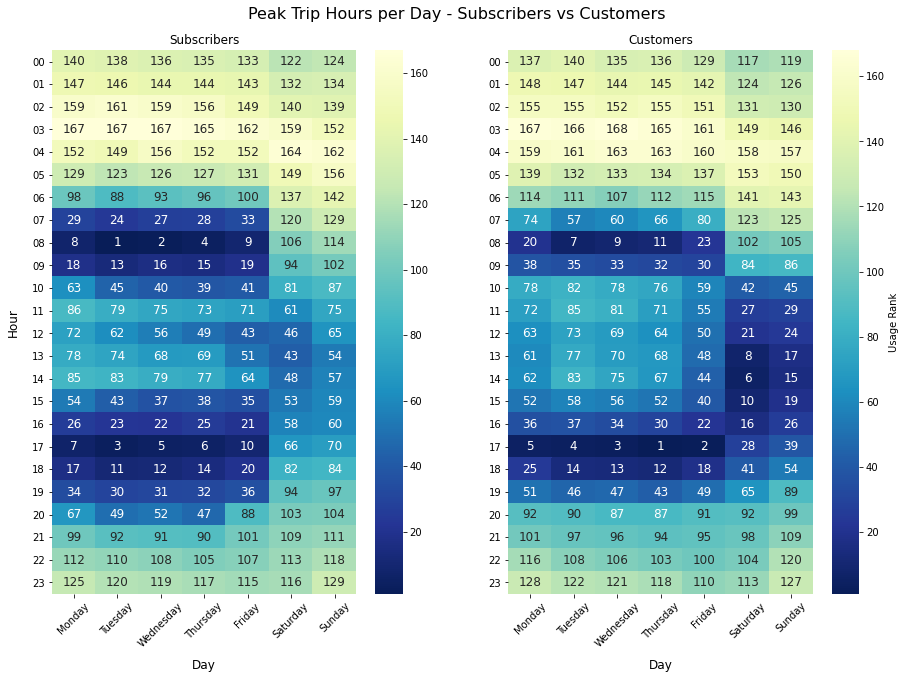

In [97]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.suptitle('Peak Hourly Usage - Subscribers vs Customers', y=0.94, fontsize=16)
sns.heatmap(subscriber_days_pivoted, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 12})
plt.title("Subscribers")
plt.xlabel('Day', labelpad=10, fontsize = 12)
plt.ylabel('Hour', labelpad=12, fontsize = 12)
plt.xticks(rotation = 45)
plt.yticks(rotation=360);

plt.subplot(122)
sns.heatmap(customer_days_pivoted, fmt='d', annot=True, cmap='YlGnBu_r',
            annot_kws={"size": 12}, cbar_kws={'label': 'Usage Rank'})
plt.title("Customers")
plt.xlabel('Day', labelpad=10, fontsize = 12)
plt.ylabel(' ')
plt.xticks(rotation = 45);
plt.yticks(rotation=360);

### Distributions of trip times per workday and weekend
- explore the spread of trip duration in minutes

In [98]:
df_minutes.duration_min.describe()

count   5795411.00
mean         14.16
std          37.23
min           1.00
25%           6.00
50%           9.53
75%          14.88
max       15201.83
Name: duration_min, dtype: float64

**There are a couple of trips that last longer than 24 hours, that are 10 days long...**

In [99]:
df_minutes.loc[df_minutes.duration_min > 60*24]

,yearmonth,user_type,start_month_name,start_day_name,start_time,end_time,duration_min,trip_count,day_type
4787980,201912,Customer,December,Thursday,2019-12-19 23:15:36,2019-12-30 12:37:26,15201.83,1,Workday
5107255,202001,Subscriber,January,Thursday,2020-01-09 16:23:21,2020-01-19 01:41:19,13517.95,1,Workday


**Distribution of minutes up to 24 hours duration**

In [100]:
df_minutes.loc[df_minutes.duration_min <= 60*24, ["duration_min"]].describe()

,duration_min
count,5795409.00
mean,14.16
std,36.26
min,1.00
25%,6.00
50%,9.53
75%,14.88
max,1439.48


**Bike Share distribution of minutes**

In [101]:
df_minutes.loc[df_minutes.bike_share_for_all_trip=='Yes', ["duration_min"]].describe()

,duration_min
count,339907.00000
mean,12.21861
std,28.63255
min,1.02000
25%,5.02000
50%,8.03000
75%,12.78000
max,1436.75000


**Distribution of minutes up to 10 hours duration**

In [102]:
df_minutes.loc[df_minutes.duration_min <= 60*10, ["duration_min"]].describe()

,duration_min
count,5790021.00
mean,13.26
std,20.24
min,1.00
25%,6.00
50%,9.52
75%,14.87
max,599.83


**Distribution of minutes up to 2 hours duration**

In [103]:
df_minutes.loc[df_minutes.duration_min <= 60*2, ["duration_min"]].describe()

,duration_min
count,5759691.00
mean,12.15
std,10.72
min,1.00
25%,5.98
50%,9.48
75%,14.75
max,120.00


**Bike Share distribution of minutes up to 2 hours duration**

In [104]:
df_minutes.loc[
    (df_minutes.bike_share_for_all_trip=='Yes') &
    (df_minutes.duration_min <= 60*2), ["duration_min"]].describe()

,duration_min
count,338824.00000
mean,11.09884
std,10.83284
min,1.02000
25%,5.00000
50%,8.02000
75%,12.72000
max,119.83000


### Distribution of minutes up to 1 hour duration
- the distribution is heavily skewed
- restricting the view to a one hour window makes it easier to view the data
- restricting to an hour, the mean is 11.5 minutes, the 50% percentile is 9.4 minutes
- unrestricted, the mean 14.1 minutes, the 50% percentile is 9.5 minutes
- Bike Share for All Trip distribution is very similar, the mean is one minute less

In [105]:
df_minutes.loc[df_minutes.duration_min <= 60, ["duration_min"]].describe()

,duration_min
count,5705188.00
mean,11.49
std,8.16
min,1.00
25%,5.95
50%,9.40
75%,14.53
max,60.00


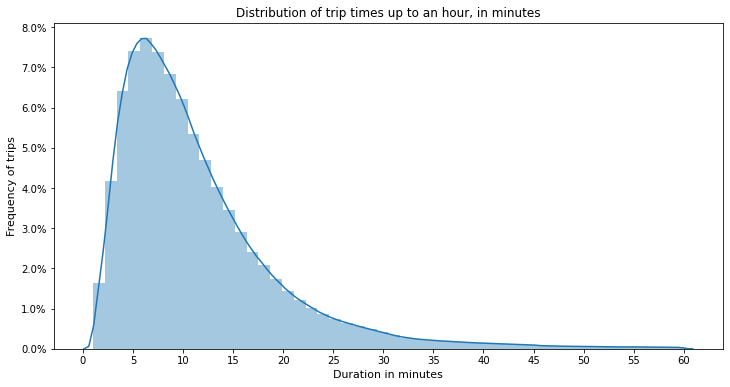

In [106]:
f = plt.figure(figsize=(12, 6))
ax = sns.distplot(df_minutes.loc[df_minutes.duration_min <= 60, ["duration_min"]]);
stepsize = 5
start, end = (0, 65)
ax.xaxis.set_ticks(np.arange(start, end, stepsize))
ax.set_xlabel('Duration in minutes', fontsize=11)
ax.set_ylabel('Frequency of trips', fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of trip times up to an hour, in minutes')
plt.show();

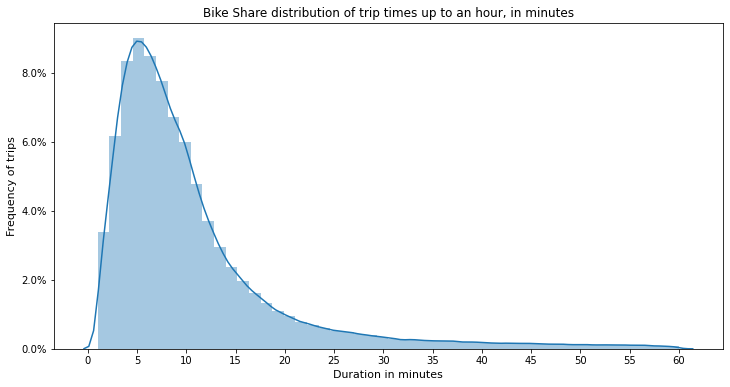

In [107]:
f = plt.figure(figsize=(12, 6))
ax = sns.distplot(df_minutes.loc[
    (df_minutes.bike_share_for_all_trip=='Yes') &
    (df_minutes.duration_min <= 60), 
    ["duration_min"]]);
stepsize = 5
start, end = (0, 65)
ax.xaxis.set_ticks(np.arange(start, end, stepsize))
ax.set_xlabel('Duration in minutes', fontsize=11)
ax.set_ylabel('Frequency of trips', fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Bike Share distribution of trip times up to an hour, in minutes')
plt.show();

### Log distribution of minutes up to 2 hours duration
- A log scale helps to visualise the data in the smaller increments where most data is found

In [108]:
df_120_min = df_minutes.loc[df_minutes.duration_min <= 120, ["duration_min", "day_type", "user_type"]]

In [109]:
df_120_min.duration_min.describe()

count   5759691.00
mean         12.15
std          10.72
min           1.00
25%           5.98
50%           9.48
75%          14.75
max         120.00
Name: duration_min, dtype: float64

In [110]:
print("For trips up to 2 hours, mean = {}, median = {}".format(
    round(df_120_min.duration_min.mean(),2), df_120_min.duration_min.median()))

For trips up to 2 hours, mean = 12.15, median = 9.48


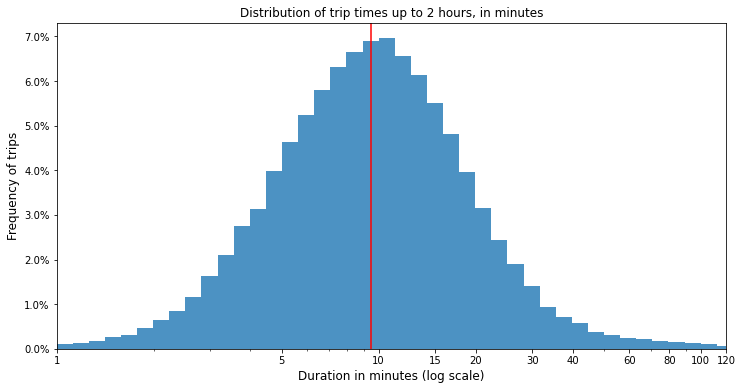

In [111]:
f = plt.figure(figsize=(12, 6))
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(df_120_min.duration_min.max()) + log_binsize, log_binsize)

plt.hist(data = df_120_min, x = 'duration_min', 
         weights=np.ones(len(df_120_min)) / len(df_120_min),
         bins = bins, alpha=0.8)
plt.xscale('log')
plt.xticks([1, 5, 10, 15, 20, 30, 40, 60, 80, 100, 120], [1, 5, 10, 15, 20, 30, 40, 60, 80, 100, 120])
plt.xlim((1, 120))
plt.xlabel('Duration in minutes (log scale)', fontsize=12)
plt.ylabel('Frequency of trips', fontsize=12)
plt.axvline(x = df_120_min.duration_min.median(), color = 'red') 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of trip times up to 2 hours, in minutes')
plt.show();

### Distribution of minutes up to 2 hours duration, by working day or weekend
- Weekend trips are longer, the distribution is not so heavily skewed as the weekday distribution
- Weekday trips have a mean of 11.5 minutes and 50% percentile of 9.3
- Weekend trips have a mean of 15.1 minutes and 50% percentile of 10.75

In [112]:
df_120_min.loc[df_120_min.day_type=="Workday", ["duration_min"]].describe()

,duration_min
count,4702864.00
mean,11.49
std,9.51
min,1.00
25%,5.90
50%,9.27
75%,14.13
max,120.00


In [113]:
print("For Workday trips up to 2 hours, mean = {}, median = {}".format(
    round(df_120_min[df_120_min.day_type=="Workday"].duration_min.mean(),2), 
          df_120_min[df_120_min.day_type=="Workday"].duration_min.median()));

For Workday trips up to 2 hours, mean = 11.49, median = 9.27


In [114]:
df_120_min.loc[df_120_min.day_type=="Weekend", ["duration_min"]].describe()

,duration_min
count,1056827.00
mean,15.10
std,14.59
min,1.00
25%,6.38
50%,10.75
75%,18.42
max,120.00


In [115]:
print("For Weekend trips up to 2 hours, mean = {}, median = {}".format(
    round(df_120_min[df_120_min.day_type=="Weekend"].duration_min.mean(),2), 
          df_120_min[df_120_min.day_type=="Weekend"].duration_min.median()));

For Weekend trips up to 2 hours, mean = 15.1, median = 10.75


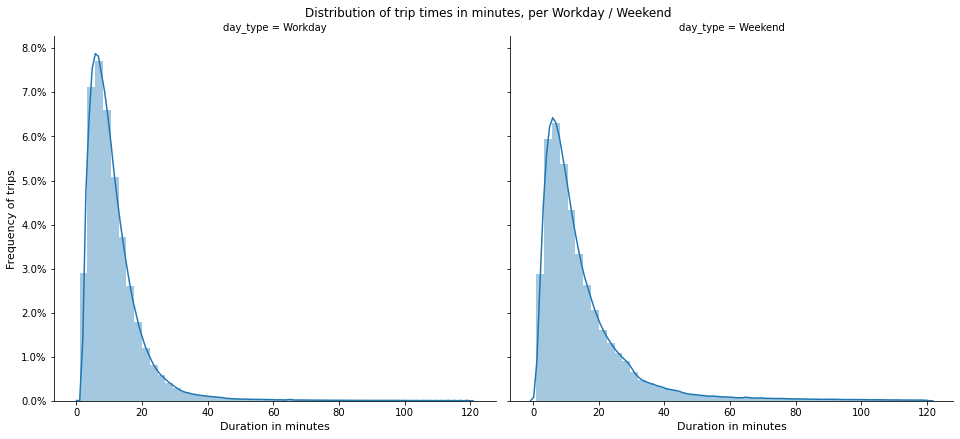

In [116]:
g = sns.FacetGrid(df_120_min, 
                  col="day_type", height=6, aspect=1.1)
g.map(sns.distplot, "duration_min")
g.fig.suptitle('Distribution of trip times in minutes, per Workday / Weekend', y=1.01)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xlabel('Duration in minutes', fontsize=11)
    if i == 0:
        ax.set_ylabel('Frequency of trips', fontsize=11)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
       
plt.show();

----

### Comparisons of average trip duration over user types

In [117]:
df_duration_summary.loc[df_duration_summary.trip_count > 1].head()

,yearmonth,user_type,age_group,member_gender,year_name,start_month_name,start_day_name,start_hour,trip_count,duration_hrs,duration_min,total_hrs,total_min,start_hour_name,day_type
8,201706,Customer,18-25,Male,2017,June,Friday,9,2,0.20000,12.00000,0.40000,24.00000,09,Workday
11,201706,Customer,18-25,Male,2017,June,Friday,16,2,0.20000,12.00000,0.40000,24.00000,16,Workday
27,201706,Customer,25-30,Female,2017,June,Thursday,10,2,0.30000,18.00000,0.60000,36.00000,10,Workday
43,201706,Customer,25-30,Male,2017,June,Thursday,12,2,0.40000,24.00000,0.80000,48.00000,12,Workday
47,201706,Customer,25-30,Male,2017,June,Thursday,18,2,1.10000,66.00000,2.20000,132.00000,18,Workday


#### Create table of summary daily values per week
- Test

In [118]:
df_duration_summary.iloc[:10]

,yearmonth,user_type,age_group,member_gender,year_name,start_month_name,start_day_name,start_hour,trip_count,duration_hrs,duration_min,total_hrs,total_min,start_hour_name,day_type
0,201706,Customer,18-25,Female,2017,June,Friday,10,1,0.20000,12.00000,0.20000,12.00000,10,Workday
1,201706,Customer,18-25,Female,2017,June,Friday,15,1,0.40000,24.00000,0.40000,24.00000,15,Workday
2,201706,Customer,18-25,Female,2017,June,Friday,17,1,0.30000,18.00000,0.30000,18.00000,17,Workday
3,201706,Customer,18-25,Female,2017,June,Thursday,18,1,0.20000,12.00000,0.20000,12.00000,18,Workday
4,201706,Customer,18-25,Female,2017,June,Thursday,18,1,0.30000,18.00000,0.30000,18.00000,18,Workday
5,201706,Customer,18-25,Female,2017,June,Thursday,19,1,0.20000,12.00000,0.20000,12.00000,19,Workday
6,201706,Customer,18-25,Female,2017,June,Wednesday,15,1,0.40000,24.00000,0.40000,24.00000,15,Workday
7,201706,Customer,18-25,Male,2017,June,Friday,8,1,0.09000,5.00000,0.09000,5.40000,08,Workday
8,201706,Customer,18-25,Male,2017,June,Friday,9,2,0.20000,12.00000,0.40000,24.00000,09,Workday
9,201706,Customer,18-25,Male,2017,June,Friday,10,1,0.20000,12.00000,0.20000,12.00000,10,Workday


In [119]:
df_trip_summary_test =\
pd.DataFrame(df_duration_summary.iloc[:10].groupby(
        ["user_type","start_day_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.iloc[:10].groupby(
    ["user_type","start_day_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])
df_trip_summary_test =\
df_trip_summary_test.merge(
pd.DataFrame(df_duration_summary.iloc[:10].groupby(
    ["user_type","start_day_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])

df_trip_summary_test["duration_hrs"] = df_trip_summary_test["total_hrs"] / df_trip_summary_test["trip_count"]
df_trip_summary_test["duration_min"] = df_trip_summary_test["total_min"] / df_trip_summary_test["trip_count"]
df_trip_summary_test.reset_index(inplace=True)
df_trip_summary_test

,user_type,start_day_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,Monday,nan,nan,nan,nan,nan
1,Customer,Tuesday,nan,nan,nan,nan,nan
2,Customer,Wednesday,1.00000,0.40000,24.00000,0.40000,24.00000
3,Customer,Thursday,3.00000,0.70000,42.00000,0.23333,14.00000
4,Customer,Friday,7.00000,1.59000,95.40000,0.22714,13.62857
5,Customer,Saturday,nan,nan,nan,nan,nan
6,Customer,Sunday,nan,nan,nan,nan,nan


- Test worked, final working version

#### Daily average trip duration by user type

In [120]:
df_trip_summary =\
pd.DataFrame(df_duration_summary.groupby(
        ["user_type","start_day_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.groupby(
    ["user_type","start_day_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])
df_trip_summary =\
df_trip_summary.merge(
pd.DataFrame(df_duration_summary.groupby(
    ["user_type","start_day_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])


df_trip_summary["duration_hrs"] = df_trip_summary["total_hrs"] / df_trip_summary["trip_count"]
df_trip_summary["duration_min"] = df_trip_summary["total_min"] / df_trip_summary["trip_count"]
df_trip_summary.reset_index(inplace=True)
df_trip_summary

,user_type,start_day_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,Monday,166775,61730.69000,3703841.40000,0.37014,22.20861
1,Customer,Tuesday,171831,59882.57000,3592954.20000,0.34850,20.90981
2,Customer,Wednesday,174510,59778.11000,3586686.60000,0.34255,20.55290
3,Customer,Thursday,179017,63499.58000,3809974.80000,0.35471,21.28275
4,Customer,Friday,191016,71526.69000,4291601.40000,0.37445,22.46724
5,Customer,Saturday,186989,96436.32000,5786179.20000,0.51573,30.94395
6,Customer,Sunday,166627,88092.94000,5285576.40000,0.52868,31.72101
7,Subscriber,Monday,736432,134349.27000,8060956.20000,0.18243,10.94596
8,Subscriber,Tuesday,800848,145418.88000,8725132.80000,0.18158,10.89487
9,Subscriber,Wednesday,793020,145074.11000,8704446.60000,0.18294,10.97633


#### Daily average trip duration by Bike Share subscribers

In [121]:
df_bike_share_trip_summary =\
pd.DataFrame(df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].groupby(
        ["user_type","start_day_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].groupby(
    ["user_type","start_day_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])
df_bike_share_trip_summary =\
df_bike_share_trip_summary.merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.bike_share_for_all_trip=='Yes'].groupby(
    ["user_type","start_day_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])


df_bike_share_trip_summary["duration_hrs"] = df_bike_share_trip_summary["total_hrs"] / df_bike_share_trip_summary["trip_count"]
df_bike_share_trip_summary["duration_min"] = df_bike_share_trip_summary["total_min"] / df_bike_share_trip_summary["trip_count"]
df_bike_share_trip_summary.reset_index(inplace=True)
df_bike_share_trip_summary

,user_type,start_day_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Subscriber,Monday,49816,9710.99000,582659.40000,0.19494,11.69623
1,Subscriber,Tuesday,53872,10185.24000,611114.40000,0.18906,11.34382
2,Subscriber,Wednesday,53479,10362.56000,621753.60000,0.19377,11.62613
3,Subscriber,Thursday,55220,10706.92000,642415.20000,0.19390,11.63374
4,Subscriber,Friday,51637,10383.98000,623038.80000,0.20110,12.06574
5,Subscriber,Saturday,39889,8955.86000,537351.60000,0.22452,13.47117
6,Subscriber,Sunday,35994,8272.18000,496330.80000,0.22982,13.78926


### Average Trip durations per week
- Customers average around 20 to 22 minutes during the week, and between 30 and 32 minutes in the weekend
- Subscribers average around 10 to 11 minutes in the week, and 13 minutes in the weekend
- Bike Share subscribers trip duration are one minute longer on average
- Customers are more casual riders and tend to ride longer, twice as long as Subscribers during the week, in the weekend three times as long

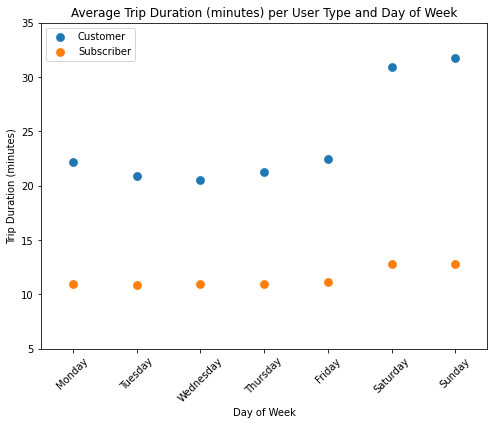

In [122]:
plt.figure(figsize=[8, 6])

sns.pointplot(data = df_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.ylim(5, 35)
plt.legend(loc='upper left')
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Day of Week')
plt.show();

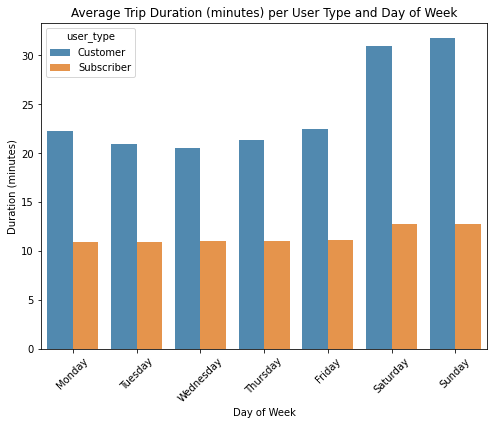

In [123]:
plt.figure(figsize=[8, 6])

sns.barplot(data = df_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type', alpha=0.85)
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Day of Week')
plt.show();

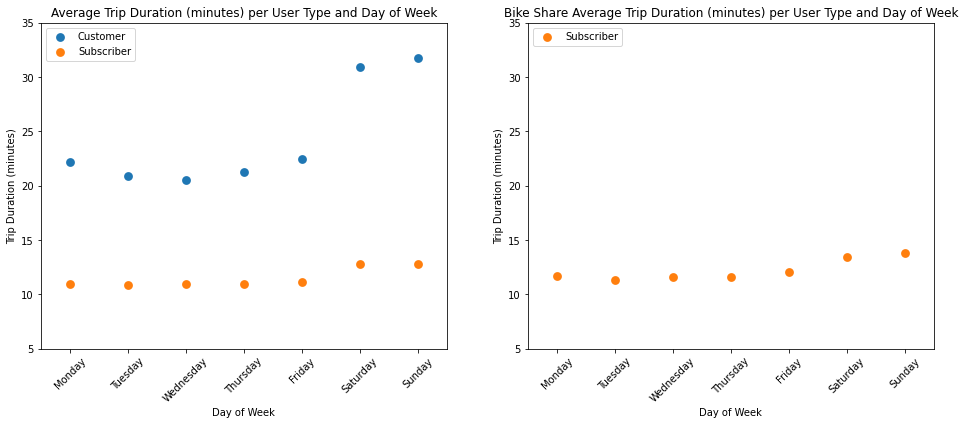

In [124]:
plt.figure(figsize=[16, 6])

plt.subplot(1, 2, 1)
sns.pointplot(data = df_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.ylim(5, 35)
plt.legend(loc='upper left')
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Day of Week')

plt.subplot(1, 2, 2)
subscriber_color = sns.color_palette()[1:]
sns.pointplot(data = df_bike_share_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "", palette=subscriber_color)
plt.ylim(5, 35)
plt.legend(loc='upper left')
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.title('Bike Share Average Trip Duration (minutes) per User Type and Day of Week')

plt.show();

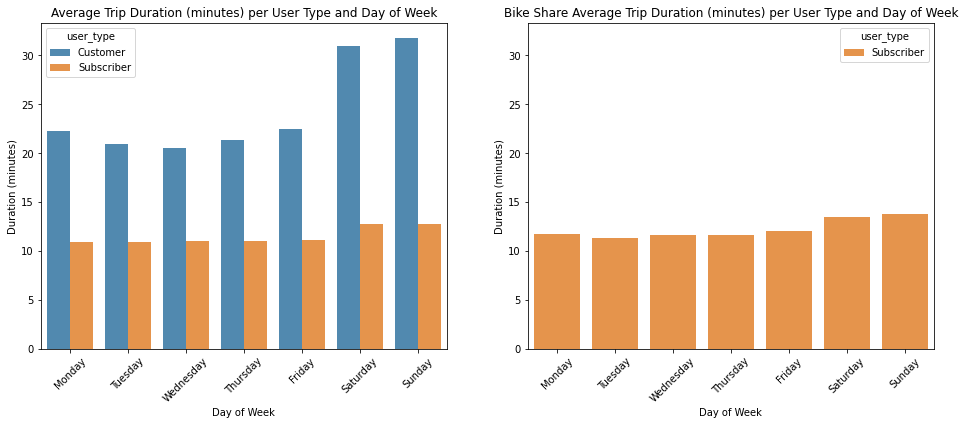

In [125]:
plt.figure(figsize=[16, 6])

plt.subplot(1, 2, 1)
sns.barplot(data = df_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type', alpha=0.85)
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Day of Week')
bottom, top = plt.ylim()

plt.subplot(1, 2, 2)
sns.barplot(data = df_bike_share_trip_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type', alpha=0.85, 
              palette=sns.color_palette()[1:])
plt.ylim(top=top)
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Bike Share Average Trip Duration (minutes) per User Type and Day of Week')

plt.show();

#### Summary values for trips up to 2 hours 

In [126]:
df_trip_120_summary =\
pd.DataFrame(df_duration_summary.loc[df_duration_summary.duration_min <= 120].groupby(
        ["user_type","start_day_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.duration_min <= 120].groupby(
    ["user_type","start_day_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])
df_trip_120_summary =\
df_trip_120_summary.merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.duration_min <= 120].groupby(
    ["user_type","start_day_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_day_name"],
    right_on=["user_type","start_day_name"])


df_trip_120_summary["duration_hrs"] = df_trip_120_summary["total_hrs"] / df_trip_120_summary["trip_count"]
df_trip_120_summary["duration_min"] = df_trip_120_summary["total_min"] / df_trip_120_summary["trip_count"]
df_trip_120_summary.reset_index(inplace=True)
df_trip_120_summary

,user_type,start_day_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,Monday,163753,43931.99000,2635919.40000,0.26828,16.09692
1,Customer,Tuesday,169019,42948.97000,2576938.20000,0.25411,15.24644
2,Customer,Wednesday,171817,43602.41000,2616144.60000,0.25377,15.22634
3,Customer,Thursday,175996,45287.78000,2717266.80000,0.25732,15.43937
4,Customer,Friday,187495,51866.39000,3111983.40000,0.27663,16.59769
5,Customer,Saturday,180835,65207.62000,3912457.20000,0.36059,21.63551
6,Customer,Sunday,160958,58663.84000,3519830.40000,0.36447,21.86801
7,Subscriber,Monday,735358,127204.17000,7632250.20000,0.17298,10.37896
8,Subscriber,Tuesday,799700,137886.48000,8273188.80000,0.17242,10.34537
9,Subscriber,Wednesday,791821,137105.31000,8226318.60000,0.17315,10.38911


### Average Trip durations per week up to 2 hours
- Restricting the view to 2 hours removes a lot of Customer data, and weekend Subscriber data
- Customers now average around 15 to 16 minutes during the week, and around 22 minutes in the weekend
- Subscribers average around 10 minutes in the week, and 11 minutes in the weekend
- With long rides by both groups eliminated the averages are less, but this is more marked with Customers

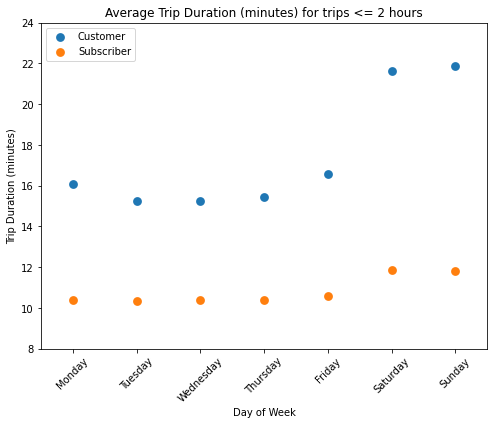

In [127]:
plt.figure(figsize=[8, 6])

sns.pointplot(data = df_trip_120_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.ylim(8, 24)
plt.legend(loc='upper left')

plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) for trips <= 2 hours')
plt.show();

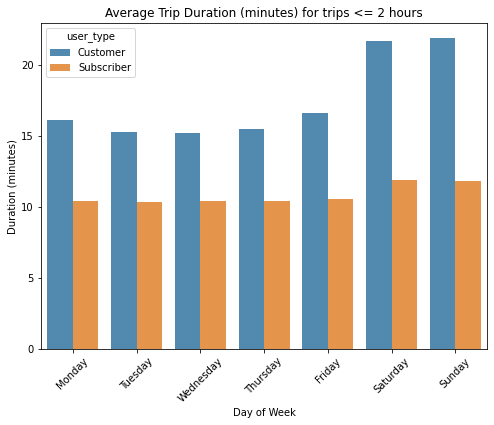

In [128]:
plt.figure(figsize=[8, 6])

sns.barplot(data = df_trip_120_summary, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type', alpha=0.85)
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Average Trip Duration (minutes) for trips <= 2 hours')
plt.show();

#### Create table of summary monthly values
- Just use complete years so we count months evenly

In [129]:
df_monthly_trip_summary =\
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
        ["user_type","start_month_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
    ["user_type","start_month_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_month_name"],
    right_on=["user_type","start_month_name"])
df_monthly_trip_summary =\
df_monthly_trip_summary.merge(
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
    ["user_type","start_month_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_month_name"],
    right_on=["user_type","start_month_name"])


df_monthly_trip_summary["duration_hrs"] = df_monthly_trip_summary["total_hrs"] / df_monthly_trip_summary["trip_count"]
df_monthly_trip_summary["duration_min"] = df_monthly_trip_summary["total_min"] / df_monthly_trip_summary["trip_count"]
df_monthly_trip_summary.reset_index(inplace=True)
df_monthly_trip_summary

,user_type,start_month_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,January,35694,17553.13000,1053187.80000,0.49177,29.50602
1,Customer,February,34729,17074.45000,1024467.00000,0.49165,29.49889
2,Customer,March,53283,26947.93000,1616875.80000,0.50575,30.34506
3,Customer,April,57094,27969.35000,1678161.00000,0.48988,29.39295
4,Customer,May,54733,25844.35000,1550661.00000,0.47219,28.33137
5,Customer,June,66410,32038.45000,1922307.00000,0.48243,28.94605
6,Customer,July,77938,36396.60000,2183796.00000,0.46699,28.01966
7,Customer,August,76354,33879.27000,2032756.20000,0.44371,26.62279
8,Customer,September,82449,34873.18000,2092390.80000,0.42297,25.37800
9,Customer,October,81281,32635.45000,1958127.00000,0.40151,24.09083


### Average trip durations per month
- Customer trip durations are highly dependent on month, they drop markedly from August to December, then jump right up again in January
- Subscriber trip durations a very slightly higher in June, July and September


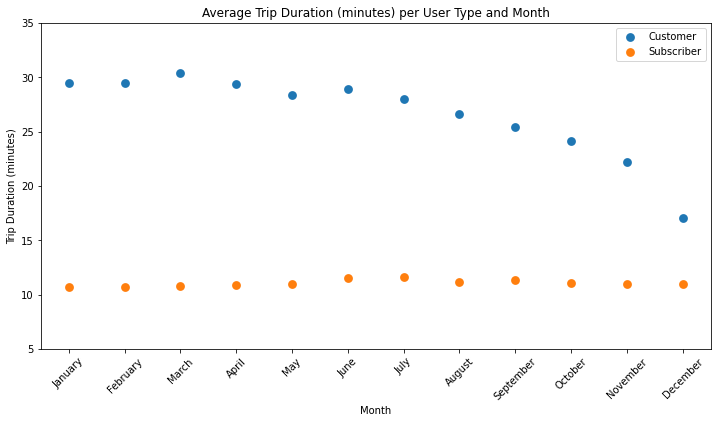

In [130]:
plt.figure(figsize=[12, 6])

sns.pointplot(data = df_monthly_trip_summary, 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.ylim(5, 35)
plt.legend(loc='upper right')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Month')
plt.show();

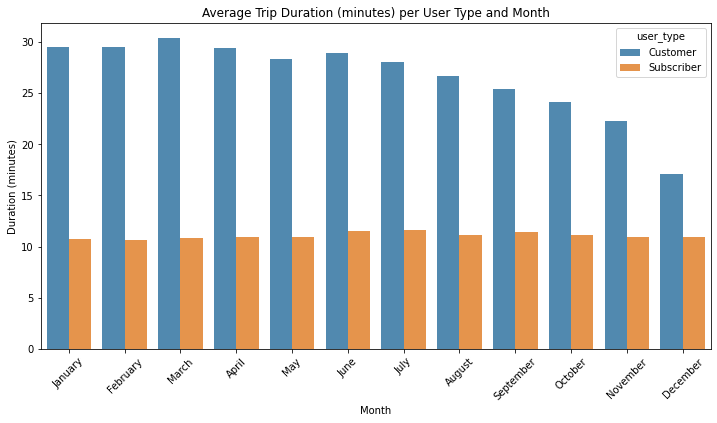

In [131]:
plt.figure(figsize=[12, 6])

ax = sns.barplot(data = df_monthly_trip_summary, 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type', alpha=0.85)
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Month')
plt.show();

### Average monthly trip durations, comparing years
- The large differences between Customers and Subscribers might be reflected in yearly differences

In [132]:
df_yearmonthly_trip_summary =\
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
        ["user_type","year_name","start_month_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
    ["user_type","year_name","start_month_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","year_name","start_month_name"],
    right_on=["user_type","year_name","start_month_name"])
df_yearmonthly_trip_summary

df_yearmonthly_trip_summary =\
df_yearmonthly_trip_summary.merge(
pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.yearmonth > '201712') & (df_duration_summary.yearmonth < '202001')].groupby(
    ["user_type","year_name","start_month_name"]).total_min.agg('sum')), 
    left_on=["user_type","year_name","start_month_name"],
    right_on=["user_type","year_name","start_month_name"])


df_yearmonthly_trip_summary["duration_hrs"] = df_yearmonthly_trip_summary["total_hrs"] / df_yearmonthly_trip_summary["trip_count"]
df_yearmonthly_trip_summary["duration_min"] = df_yearmonthly_trip_summary["total_min"] / df_yearmonthly_trip_summary["trip_count"]
df_yearmonthly_trip_summary.reset_index(inplace=True)
df_yearmonthly_trip_summary

,user_type,year_name,start_month_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,2018,January,12344,7943.80000,476628.00000,0.64354,38.61212
1,Customer,2018,February,14861,9192.83000,551569.80000,0.61859,37.11525
2,Customer,2018,March,16307,10114.58000,606874.80000,0.62026,37.21560
3,Customer,2018,April,21180,12767.60000,766056.00000,0.60281,36.16884
4,Customer,2018,May,29239,14890.07000,893404.20000,0.50925,30.55522
5,Customer,2018,June,32883,17742.05000,1064523.00000,0.53955,32.37305
6,Customer,2018,July,33979,18366.41000,1101984.60000,0.54052,32.43134
7,Customer,2018,August,30719,16167.28000,970036.80000,0.52630,31.57775
8,Customer,2018,September,30093,15152.20000,909132.00000,0.50351,30.21075
9,Customer,2018,October,26243,12593.64000,755618.40000,0.47989,28.79314


#### There is a lot of variation in the Customers figures, but not the subscribers

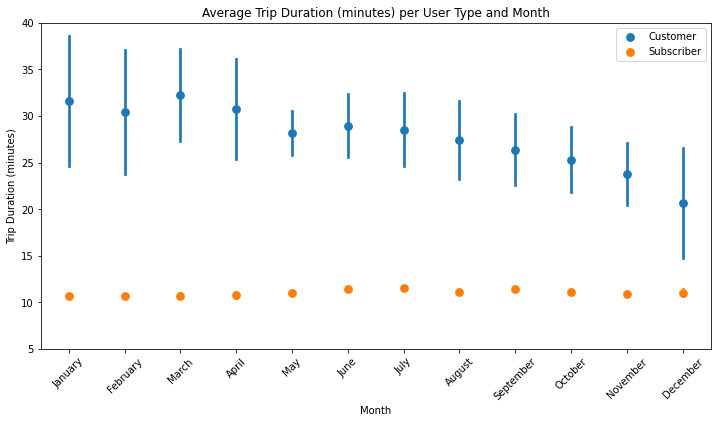

In [133]:
plt.figure(figsize=[12, 6])

sns.pointplot(data = df_yearmonthly_trip_summary, 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.ylim(5, 40)
plt.legend(loc='upper right')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) per User Type and Month')
plt.show();

#### Trip duration has decreased amongst Customers from 2018 to 2019

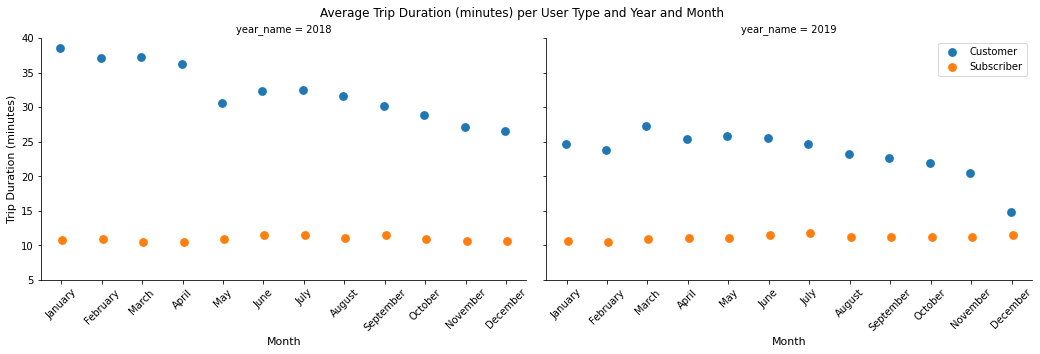

In [134]:
g = sns.catplot(x="start_month_name", y="duration_min",
                hue="user_type", col="year_name",
                data=df_yearmonthly_trip_summary, kind="point",
                dodge=True,
                linestyles = "",
                legend=False,
                height=4.3, aspect=1.7)
plt.ylim(5, 40)
plt.legend(loc='upper right')

g.fig.suptitle('Average Trip Duration (minutes) per User Type and Year and Month', y=1.02, fontsize=12)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Month', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Duration (minutes)', fontsize=11)
plt.show();

#### To understand current usage use the 2019 year only

In [135]:
df_2019_monthly_summary =\
pd.DataFrame(df_duration_summary.loc[df_duration_summary.year_name == '2019'].groupby(
        ["user_type","start_month_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.year_name == '2019'].groupby(
    ["user_type","start_month_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","start_month_name"],
    right_on=["user_type","start_month_name"])
df_2019_monthly_summary =\
df_2019_monthly_summary.merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.year_name == '2019'].groupby(
    ["user_type","start_month_name"]).total_min.agg('sum')), 
    left_on=["user_type","start_month_name"],
    right_on=["user_type","start_month_name"])


df_2019_monthly_summary["duration_hrs"] = df_2019_monthly_summary["total_hrs"] / df_2019_monthly_summary["trip_count"]
df_2019_monthly_summary["duration_min"] = df_2019_monthly_summary["total_min"] / df_2019_monthly_summary["trip_count"]
df_2019_monthly_summary.reset_index(inplace=True)
df_2019_monthly_summary

,user_type,start_month_name,trip_count,total_hrs,total_min,duration_hrs,duration_min
0,Customer,January,23350,9609.33000,576559.80000,0.41153,24.69207
1,Customer,February,19868,7881.62000,472897.20000,0.39670,23.80195
2,Customer,March,36976,16833.35000,1010001.00000,0.45525,27.31504
3,Customer,April,35914,15201.75000,912105.00000,0.42328,25.39692
4,Customer,May,25494,10954.28000,657256.80000,0.42968,25.78084
5,Customer,June,33527,14296.40000,857784.00000,0.42641,25.58487
6,Customer,July,43959,18030.19000,1081811.40000,0.41016,24.60955
7,Customer,August,45635,17711.99000,1062719.40000,0.38812,23.28738
8,Customer,September,52356,19720.98000,1183258.80000,0.37667,22.60025
9,Customer,October,55038,20041.81000,1202508.60000,0.36414,21.84870


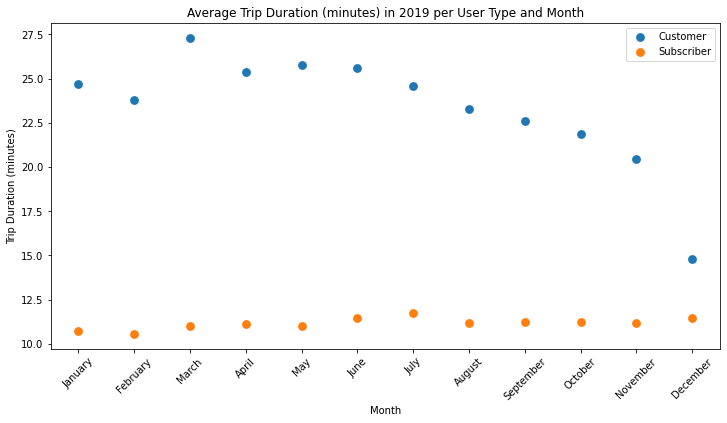

In [136]:
plt.figure(figsize=[12, 6])

sns.pointplot(data = df_2019_monthly_summary, 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
#plt.ylim(5, 35)
plt.legend(loc='upper right')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Trip Duration (minutes)')
plt.title('Average Trip Duration (minutes) in 2019 per User Type and Month')
plt.show();

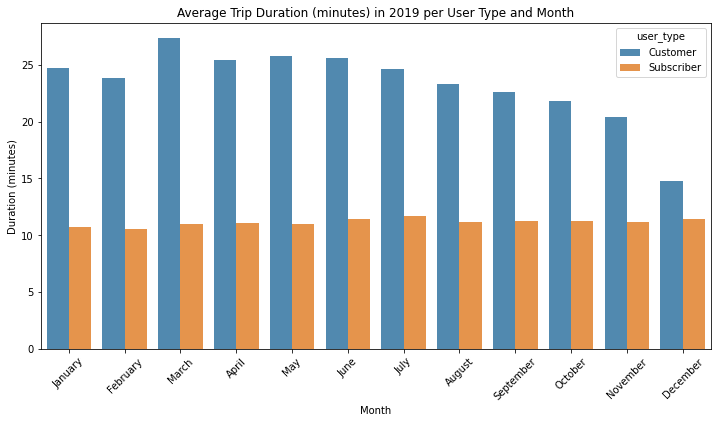

In [137]:
plt.figure(figsize=[12, 6])

ax = sns.barplot(data = df_2019_monthly_summary, 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type', alpha=0.85)
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Duration (minutes)')
plt.title('Average Trip Duration (minutes) in 2019 per User Type and Month')
plt.show();

## Trip duration conclusion
- Average trip duration varies based on workday or weekend, but most trips are within 20 minutes
- Subscribers trip times hardly vary year on year and are shorter than Customers
- However, Customers trip times have steadily fallen over the 2018 and 2019 years
- Within trips of no more than 2 hours:
    - Customers average around 15 to 16 minutes during the week, and around 22 minutes in the weekend
    - Subscribers average around 10 minutes in the week, and 11 minutes in the weekend

----

## 4. Gender and Age trip counts analysis
- the field `member_gender` stores gender, but it is only available between the initial 201706 and 201904 `yearmonth` buckets
- the values are 'Male', 'Female' and 'Other'
- the missing values have been assigned the value 'Unknown'
- it is treated as a categorical field, sorted by the descending count numbers, but with 'Unknown' last
<br><br>
- the field `member_birth_year` was also limited to the 201706 to 201904 `yearmonth` buckets 
- `member_age` was been derived from corrected `member_birth_year` 
    - `member_birth_year` was assumed wrong where resulting age values were invalid and where key transposition seemed the likely cause, 
    - therefore, `member_age` was corrected based on an assumption of the correct entry
- `age_group` was then derived from the age values based on distributions and is used here

### Gender

In [138]:
df_duration_summary.groupby("member_gender").trip_count.sum()

member_gender
Male       2251128
Female      735690
Other        49774
Unknown    2758819
Name: trip_count, dtype: int64

In [139]:
print("Proportion of Male to Female is {}x, and of these to Other is {}x".format(
        round(2251128 / 735690,1),
        round((2251128 + 735690) / 49774)
        ))

Proportion of Male to Female is 3.1x, and of these to Other is 60x


In [140]:
df_duration_summary.loc[df_duration_summary.member_gender != 'Unknown'].groupby("yearmonth").trip_count.sum()

yearmonth
201706      2387
201707     35910
201708     69783
201709     85437
201710     95336
201711     86129
201712     78256
201801     87001
201802     98662
201803    102385
201804    121827
201805    167413
201806    183402
201807    186832
201808    181287
201809    176338
201810    192818
201811    129037
201812    126352
201901    182365
201902    175147
201903    244576
201904    227912
Name: trip_count, dtype: int64

In [141]:
df_gender_unique = pd.DataFrame(df_duration_summary.loc[df_duration_summary.member_gender != 'Unknown',
                      ["yearmonth", "member_gender", "trip_count"]].groupby(
                      ["yearmonth", "member_gender"]).trip_count.sum().reset_index())
df_gender_unique.dropna(inplace=True)
df_gender_unique.reset_index(inplace=True, drop=True)
df_gender_unique["trip_count"] = df_gender_unique.trip_count.astype(int)

In [142]:
df_gender_unique.head()

,yearmonth,member_gender,trip_count
0,201706,Male,2000
1,201706,Female,374
2,201706,Other,13
3,201707,Male,28100
4,201707,Female,7483


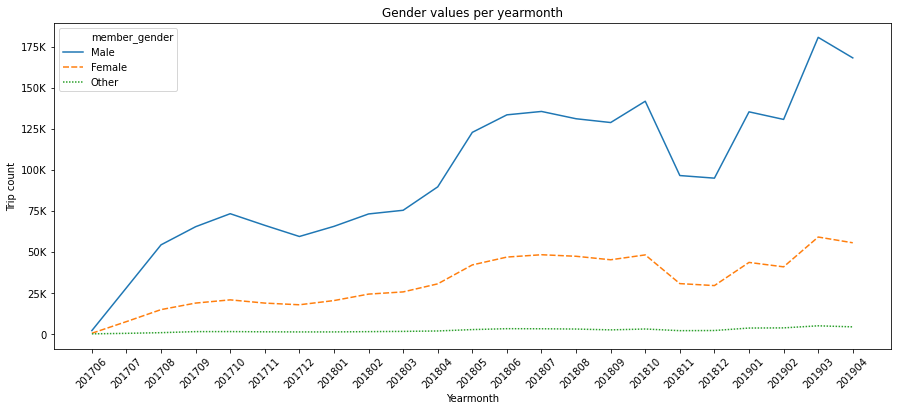

In [143]:
f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="yearmonth", y="trip_count",
                  hue="member_gender", 
                  style="member_gender", 
                  data=df_gender_unique)
plt.title("Gender values per yearmonth")
plt.xlabel('Yearmonth')
plt.ylabel('Trip count')
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.xticks(rotation=45);

### Gender Observations
- Gender data does not exist beyond April 2014...
- Male users outnumber females by two to three times
- Gender "Other" is very much smaller than the other genders, and presents issues with comparative charts, so will not be used

----

### Age and age group
- Age trip counts is skewed to favor 30 to 35 year olds

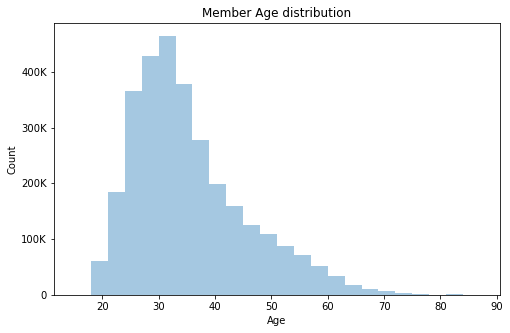

In [144]:
f = plt.figure(figsize=(8, 5))
bin_edges = np.arange(15, df_minutes.member_age.max()+1, 3)
sns.distplot(df_minutes.member_age, bins=bin_edges, kde=False)
plt.title("Member Age distribution")
plt.xlabel('Age')
plt.ylabel('Count')
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))

plt.show();

Age is also only available from 201706 through to 201904, and not in all records

In [145]:
df_duration_summary.loc[df_duration_summary.age_group != 'Unknown'].groupby("yearmonth").trip_count.sum()

yearmonth
201706      2387
201707     35893
201708     69743
201709     85410
201710     95279
201711     86074
201712     78205
201801     86846
201802     98523
201803    102338
201804    121761
201805    167232
201806    183318
201807    186777
201808    181231
201809    176278
201810    192783
201811    129030
201812    126352
201901    182358
201902    175142
201903    244563
201904    227885
Name: trip_count, dtype: int64

### Create summary dataframes to explain age and gender

In [146]:
df_age_gender = pd.DataFrame(df_duration_summary.loc[
        (df_duration_summary.member_gender.isin(['Male','Female'])) & (df_duration_summary.age_group != 'Unknown'),
                      ["yearmonth", "member_gender", "age_group", "trip_count"]].groupby(
                      ["yearmonth", "member_gender", "age_group"]).trip_count.sum().reset_index())
df_age_gender.dropna(inplace=True)
df_age_gender.reset_index(inplace=True, drop=True)
df_age_gender["trip_count"] = df_age_gender.trip_count.astype(int)

In [147]:
age_gender_var_dict = {'member_gender': ['Male','Female'],
                       'age_group': ['18-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','60-70','70+']
                   }

In [148]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)
for var in age_gender_var_dict:
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = age_gender_var_dict[var])
        df_age_gender[var] = df_age_gender[var].astype(ordered_var)
    else:
        df_age_gender[var] = df_age_gender[var].astype('category', ordered = True,
                                                             categories = age_gender_var_dict[var])

In [149]:
df_age_gender.head()

,yearmonth,member_gender,age_group,trip_count
0,201706,Male,18-25,97
1,201706,Male,25-30,325
2,201706,Male,30-35,417
3,201706,Male,35-40,308
4,201706,Male,40-45,279


In [150]:
df_age_gender_dist = df_minutes.loc[df_minutes.member_gender.notna() & df_minutes.member_age.notna(), 
                                    ["member_gender","member_age","trip_count"]].copy()

In [151]:
gender_var_dict = {'member_gender': ['Male','Female','Other']}

In [152]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)

for var in gender_var_dict:
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = gender_var_dict[var])
        df_age_gender_dist[var] = df_age_gender_dist[var].astype(ordered_var)
    else:
        df_age_gender_dist[var] = df_age_gender_dist[var].astype('category', ordered = True,
                                                             categories = gender_var_dict[var])  

In [153]:
df_age_mf_dist = df_minutes.loc[df_minutes.member_gender.isin(['Male','Female']) & df_minutes.member_age.notna(), 
                                    ["member_gender","member_age","user_type","trip_count"]].copy()

In [154]:
gender_mf_var_dict = {'member_gender': ['Male','Female']}

In [155]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)

for var in gender_mf_var_dict:
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = gender_mf_var_dict[var])
        df_age_mf_dist[var] = df_age_mf_dist[var].astype(ordered_var)
    else:
        df_age_mf_dist[var] = df_age_mf_dist[var].astype('category', ordered = True,
                                                             categories = gender_mf_var_dict[var])  

In [156]:
bin_edges = np.arange(15, df_age_mf_dist.member_age.max()+1, 3)
bin_edges

array([15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 45., 48., 51.,
       54., 57., 60., 63., 66., 69., 72., 75., 78., 81., 84., 87.])

In [157]:
bin_edges = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
bin_names = ["18-20","20-25","25-30","30-35","35-40","40-45","45-50","50-55",
             "55-60","60-65","65-70","70-75","75-80","80-85","85-90"]

### Distributions of Age vs User Type
- 25 to 35 year olds dominate, but the Subscribers have a wider range and tend to be older than Customers
- Bike Share subscribers are much more likely to be in the 20-25 years age group, with another smaller peak around 45 years of age

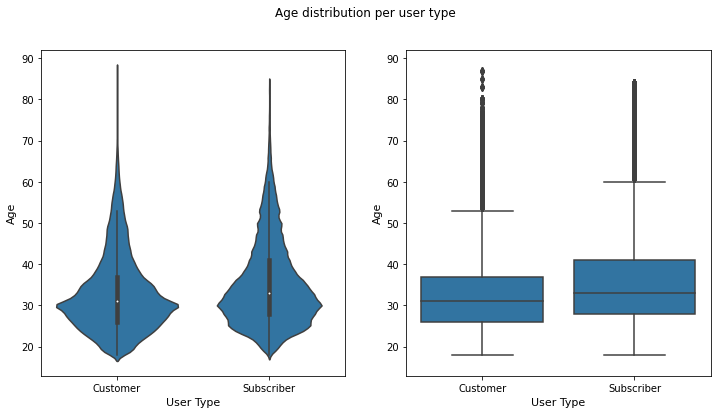

In [158]:
base_color = sns.color_palette()[0]
plt.figure(figsize = [12, 6])

plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = df_age_mf_dist, x = 'user_type', y = 'member_age', color = base_color)
ax1.set_xlabel('User Type', fontsize=11)
ax1.set_ylabel('Age', fontsize=11)

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data = df_age_mf_dist, x = 'user_type', y = 'member_age', color = base_color)
ax2.set_xlabel('User Type', fontsize=11)
ax2.set_ylabel('Age', fontsize=11)

plt.ylim(ax1.get_ylim())

plt.suptitle("Age distribution per user type")

plt.show(); 

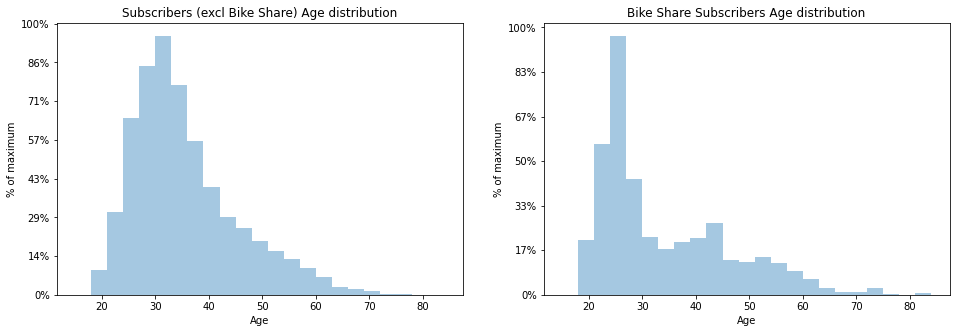

In [159]:
f = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
bin_edges = np.arange(15, df_minutes.loc[
    (df_minutes.user_type=='Subscriber') &
    (df_minutes.bike_share_for_all_trip!='Yes')].member_age.max()+1, 3)
sns.distplot(df_minutes.loc[
    (df_minutes.user_type=='Subscriber') &
    (df_minutes.bike_share_for_all_trip!='Yes')].member_age, bins=bin_edges, kde=False)
plt.title("Subscribers (excl Bike Share) Age distribution")
plt.xlabel('Age')
plt.ylabel('% of maximum')
perc_fmt = 350000 
plt.gca().yaxis.set_major_formatter(PercentFormatter(perc_fmt
                                                    , decimals=0
                                                    ))
plt.subplot(1, 2, 2)
bin_edges = np.arange(15, df_minutes.loc[df_minutes.bike_share_for_all_trip=='Yes'].member_age.max()+1, 3)
sns.distplot(df_minutes.loc[df_minutes.bike_share_for_all_trip=='Yes'].member_age, bins=bin_edges, kde=False)
plt.title("Bike Share Subscribers Age distribution")
plt.xlabel('Age')
plt.ylabel('% of maximum')
perc_fmt = 60000
plt.gca().yaxis.set_major_formatter(PercentFormatter(perc_fmt
                                                    , decimals=0
                                                    ))

plt.show();

### Distributions of Age vs Gender

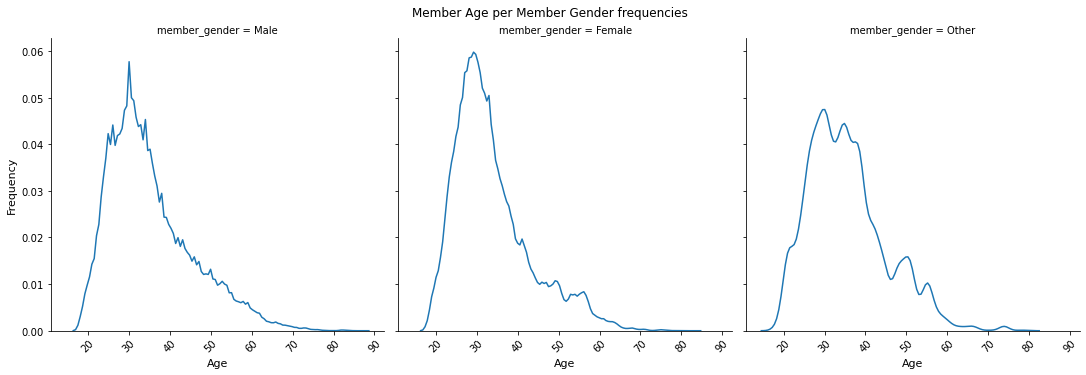

In [160]:
g = sns.FacetGrid(df_age_gender_dist, col="member_gender", height=5)
g.map(sns.kdeplot, "member_age")
plt.suptitle("Member Age per Member Gender frequencies", y=1.02, fontsize=12)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Age', fontsize=11)
    if i == 0:
        ax.set_ylabel('Frequency', fontsize=11)

plt.show();

### Distributions of Age vs Male and Female gender
- The 'Other' gender is not included as the numbers are almost invisible and including them makes it more difficult to visualize the main genders

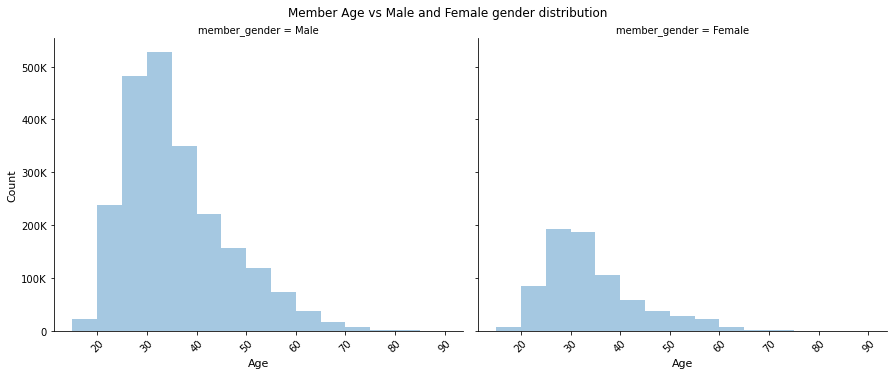

In [161]:
g = sns.FacetGrid(df_age_mf_dist, 
                  col="member_gender", height=5, aspect=1.25)
g.map(sns.distplot, "member_age", kde=False, bins=bin_edges)
plt.suptitle("Member Age vs Male and Female gender distribution", y=1.02, fontsize=12)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Age', fontsize=11)
    if i == 0:
        ax.set_ylabel('Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.show();

### Distributions of Age Groups vs Male and Female gender
- As with the age distribution, age groups show users are mostly between 25 and 35 years old, with women tending to be younger

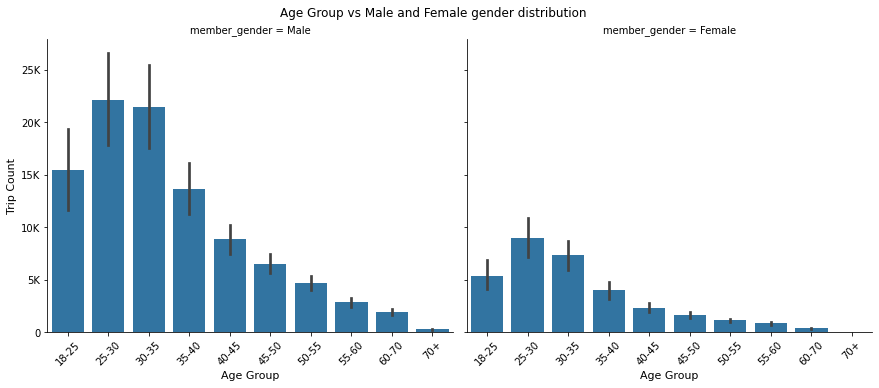

In [162]:
base_color = sns.color_palette()[0]
g = sns.catplot(x="age_group", y="trip_count",
                col="member_gender",
                color = base_color,
                data=df_age_gender, 
                kind="bar",
                height=5, aspect=1.25);
g.set_xticklabels(rotation=45)

plt.suptitle("Age Group vs Male and Female gender distribution", y=1.02, fontsize=12)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Age Group', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
        
plt.show();

### Trips counts by Age Groups over time
- over time, the 25-30 year olds dominate 30-35 and 18-25 year olds, but with the latter growing in trip counts
- there is not so much trend of greater growth in any other age groups, apart from the effect of an increase of total counts

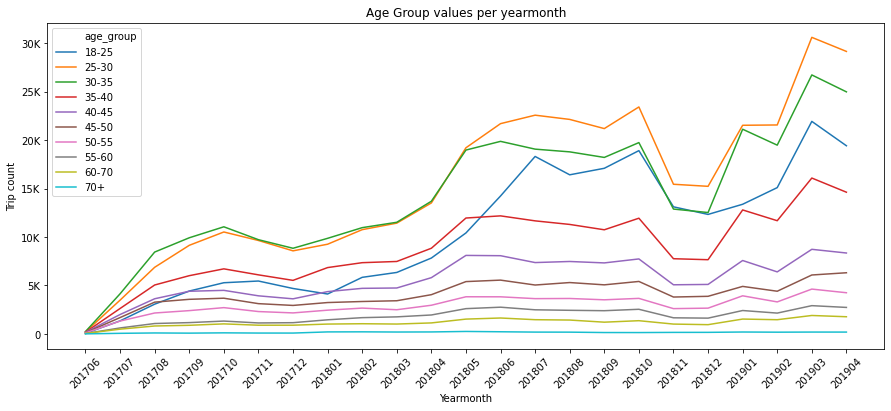

In [163]:
f = plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="yearmonth", y="trip_count",
                  hue="age_group", 
                  data=df_age_gender,
                 ci=None)
plt.title("Age Group values per yearmonth")
plt.xlabel('Yearmonth')
plt.ylabel('Trip count')
ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
plt.xticks(rotation=45);

### Trips counts by Age Groups and Gender over time
- The same trends exist between genders, only the Male group has greater numbers which amplifies any trends

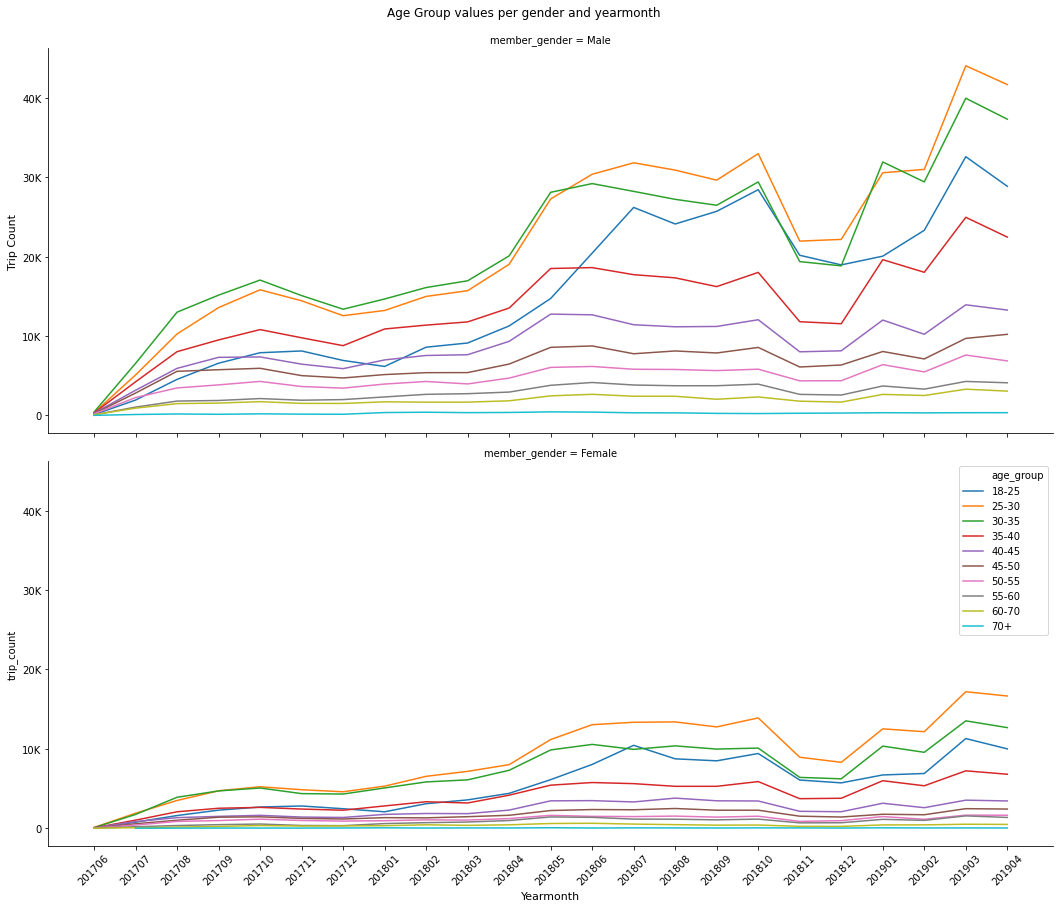

In [164]:
g = sns.FacetGrid(df_age_gender, row="member_gender", height=6, aspect=2.5)
cht = g.map(sns.lineplot, "yearmonth", "trip_count", "age_group", ci=None)

plt.suptitle("Age Group values per gender and yearmonth", y=1.02)
for (i, ax) in enumerate(cht.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Yearmonth', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))
        
plt.legend()
plt.show();

### Distributions of Gender vs User Type 
- Based on trip count, a greater proportion of both Male and Female are Subscribers vs Customers
- The previously observed greater number of Male vs Female is again also apparent 
- However, there is a closer ratio of Male to Female with Customers, the largest ratio difference is with Subscribers

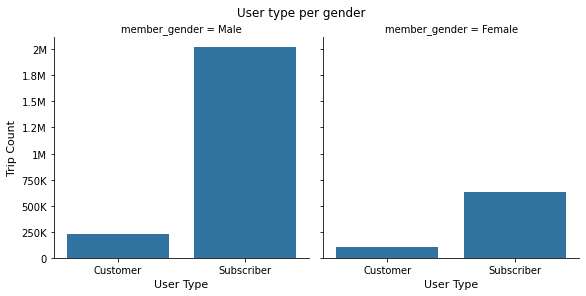

In [165]:
g = sns.FacetGrid(df_age_mf_dist, col="member_gender", height=4) #, aspect=1.25)
cht = g.map(sns.countplot, "user_type")
plt.suptitle("User type per gender", y=1.02)
for (i, ax) in enumerate(cht.axes.flatten()):
    ax.set_xlabel('User Type', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))        
plt.show(); 

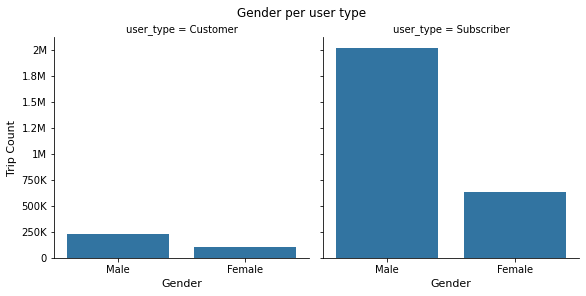

In [166]:
g = sns.FacetGrid(df_age_mf_dist, col="user_type", height=4) #, aspect=1.25)
cht = g.map(sns.countplot, "member_gender")
plt.suptitle("Gender per user type", y=1.02)
for (i, ax) in enumerate(cht.axes.flatten()):
    ax.set_xlabel('Gender', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Count', fontsize=11)
        ax.yaxis.set_major_formatter(FuncFormatter(reformat_large_tick_values))        
plt.show(); 

----

In [167]:
def day_ut_mf_freq(x):
    return round(x.duration_min / 
                 df_mf_trip_summary.loc[(df_mf_trip_summary.start_day_name == x.start_day_name)
                                      & (df_mf_trip_summary.user_type == x.user_type) ]["duration_min"].sum(), 5)

In [168]:
df_mf_trip_summary =\
pd.DataFrame(df_duration_summary.loc[df_duration_summary.member_gender.isin(["Male","Female"])].groupby(
        ["user_type","member_gender","start_day_name"]).trip_count.agg('sum')).merge(
pd.DataFrame(df_duration_summary.loc[df_duration_summary.member_gender.isin(["Male","Female"])].groupby(
    ["user_type","member_gender","start_day_name"]).total_hrs.agg('sum')), 
    left_on=["user_type","member_gender","start_day_name"],
    right_on=["user_type","member_gender","start_day_name"])

df_mf_trip_summary =\
df_mf_trip_summary.merge(
pd.DataFrame(df_duration_summary.groupby(
    ["user_type","member_gender","start_day_name"]).total_min.agg('sum')), 
    left_on=["user_type","member_gender","start_day_name"],
    right_on=["user_type","member_gender","start_day_name"])

df_mf_trip_summary.dropna(inplace=True)
df_mf_trip_summary["duration_hrs"] = df_mf_trip_summary["total_hrs"] / df_mf_trip_summary["trip_count"]
df_mf_trip_summary["duration_min"] = df_mf_trip_summary["total_min"] / df_mf_trip_summary["trip_count"]
df_mf_trip_summary.reset_index(inplace=True)

df_mf_trip_summary["day_mf_freq"] = df_mf_trip_summary.apply(lambda x: day_ut_mf_freq(x), axis=1)

In [169]:
df_mf_trip_summary

,user_type,member_gender,start_day_name,trip_count,total_hrs,total_min,duration_hrs,duration_min,day_mf_freq
0,Customer,Male,Monday,28624.00000,11045.16000,662709.60000,0.38587,23.15224,0.45014
1,Customer,Male,Tuesday,30825.00000,11329.86000,679791.60000,0.36755,22.05326,0.44248
2,Customer,Male,Wednesday,31378.00000,11614.57000,696874.20000,0.37015,22.20901,0.45101
3,Customer,Male,Thursday,33986.00000,12475.21000,748512.60000,0.36707,22.02415,0.46297
4,Customer,Male,Friday,36443.00000,14152.57000,849154.20000,0.38835,23.30089,0.44401
5,Customer,Male,Saturday,37968.00000,19184.91000,1151094.60000,0.50529,30.31749,0.46521
6,Customer,Male,Sunday,32870.00000,16810.13000,1008607.80000,0.51141,30.68475,0.46656
7,Customer,Female,Monday,12971.00000,6113.88000,366832.80000,0.47135,28.28100,0.54986
8,Customer,Female,Tuesday,12561.00000,5817.25000,349035.00000,0.46312,27.78720,0.55752
9,Customer,Female,Wednesday,13053.00000,5881.30000,352878.00000,0.45057,27.03425,0.54899


In [170]:
gender_mf_var_dict = {'member_gender': ['Male','Female']}

In [171]:
pd_ver = pd.__version__.split(".")
v021 = (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21)

for var in gender_mf_var_dict:
    if v021: # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = gender_mf_var_dict[var])
        df_mf_trip_summary[var] = df_mf_trip_summary[var].astype(ordered_var)
    else:
        df_mf_trip_summary[var] = df_mf_trip_summary[var].astype('category', ordered = True,
                                                             categories = gender_mf_var_dict[var])  

### Average Trip durations per week by gender
- The plot shows the difference between Customer and Subscriber times that previous analysis has revealed
- It also splits the data between Male and Female
- With the gender split it can be seen that Females trip durations are on average 5 minutes longer, the ratio is around 5.5 : 4.5, or 10%

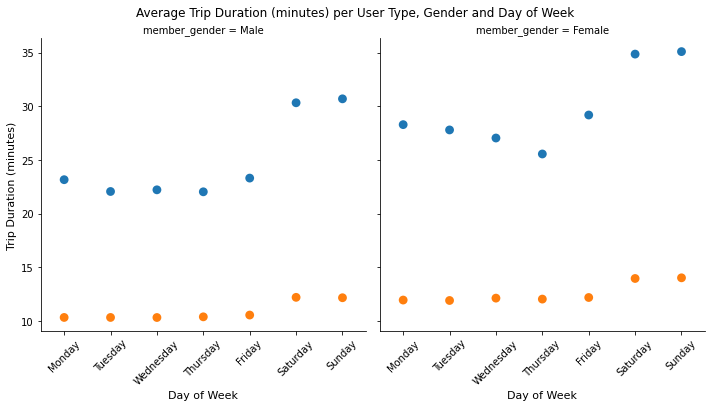

In [172]:

g = sns.FacetGrid(df_mf_trip_summary.loc[df_mf_trip_summary.member_gender.isin(["Male","Female"])], 
                  col="member_gender", hue = 'user_type', height=5)
g.map(sns.pointplot, 'start_day_name', 'duration_min',  
            linestyles = "")

plt.suptitle("Average Trip Duration (minutes) per User Type, Gender and Day of Week", y=1.02, fontsize=12)
for (i, ax) in enumerate(g.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('Day of Week', fontsize=11)
    if i == 0:
        ax.set_ylabel('Trip Duration (minutes)', fontsize=11)

plt.show();

### Gender and Age Conclusions
- Gender and Age data does not exist beyond April 2014
- Subscribers tend to be older than Customers
- Male users outnumber females by two to three times
- There a higher proportion of Male to Female with Subscribers than with Customers
- The range of and distributions of ages between men and women is roughly similar
- However, older women are unlikely customers compared to men
- Women also have a peak of numbers slightly less than men, around 25 vs 30 to 35 for men
- Women take around 10% longer for their trips

----

**Close data sources not used any more...**

In [173]:
del df_duration_summary
del df_minutes
del summary_hrs
del summary_bike_share_hrs
del summary_days
del summary_bike_share_days
del df_trip_summary


In [174]:
del df_monthly_trip_summary
del df_yearmonthly_trip_summary

In [175]:
del df_120_min
del df_trip_120_summary
del df_2019_monthly_summary

In [176]:
del customer_days
del customer_days_pivoted
del subscriber_days
del subscriber_days_pivoted

In [177]:
del df_age_mf_dist
del df_age_gender
del df_age_gender_dist
del df_age_mf_dist
del df_gender_unique
del df_mf_trip_summary

## 5. Geographic Analysis
- Bike trips record starting and finishing geographic points
- Many of these are associated with a station identifier, but there are others which have no station
- There are three main groups, and a few outliers
- Exploratory analysis has just looked at these as groups of data
- Explanatory analysis views geographical information using the on-line version of the Uber developed mapping application [kepler.gl](https://kepler.gl)
- Do do this, data is exported in CSV form, imported to kepler.gl, interacted with from the web browser, and exported as images for this notebook

In [178]:
query = '''SELECT yearmonth, 
user_type,
ifnull(bike_share_for_all_trip, 'Unknown') AS bike_share_for_all_trip,
ifnull(age_group, 'Unknown') AS age_group, 
ifnull(member_gender, 'Unknown') AS member_gender,
start_year,
start_yearmonth,
start_month_name,
start_day_name,
start_date,
start_time,
end_time,
duration_sec,
duration_min,
start_station_latitude, 
start_station_longitude, 
end_station_latitude, 
end_station_longitude, 
start_station_id, 
has_start_id, 
ifnull(start_station_name, '') AS start_station_name, 
has_start_name, 
end_station_id, 
has_end_id, 
ifnull(end_station_name, '') AS end_station_name, 
has_end_name, 
reccount AS trip_count 
FROM tripdata_fixed
'''

In [179]:
%%time
df_latlong_detail = load_from_sql(query)

Wall time: 4min 26s


In [180]:
df_latlong_detail["start_time"] = pd.to_datetime(df_latlong_detail["start_time"])
df_latlong_detail["end_time"] = pd.to_datetime(df_latlong_detail["end_time"])
df_latlong_detail["start_date"] = pd.to_datetime(df_latlong_detail["start_date"])

In [181]:
df_latlong_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5795411 entries, 0 to 5795410
Data columns (total 27 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   yearmonth                object        
 1   user_type                object        
 2   bike_share_for_all_trip  object        
 3   age_group                object        
 4   member_gender            object        
 5   start_year               int64         
 6   start_yearmonth          object        
 7   start_month_name         object        
 8   start_day_name           object        
 9   start_date               datetime64[ns]
 10  start_time               datetime64[ns]
 11  end_time                 datetime64[ns]
 12  duration_sec             int64         
 13  duration_min             float64       
 14  start_station_latitude   float64       
 15  start_station_longitude  float64       
 16  end_station_latitude     float64       
 17  end_station_longitude    fl

In [182]:
df_latlong_detail.head()

,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_date,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
0,201712,Customer,Unknown,25-30,Male,2017,201712,December,Sunday,2017-12-31,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,80110,1335.1666666667,37.7764348192,-122.4262440205,37.7787677000,-122.4159292000,74,1,Laguna St at Hayes St,1,43,1,San Francisco Public Library (Grove St at Hyde St),1,1
1,201712,Customer,Unknown,50-55,Female,2017,201712,December,Sunday,2017-12-31,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,78800,1313.3333333333,37.7848720844,-122.4008756876,37.7662102000,-122.4266136000,284,1,Yerba Buena Center for the Arts (Howard St at 3rd St),1,96,1,Dolores St at 15th St,1,1
2,201712,Customer,Unknown,Unknown,Unknown,2017,201712,December,Sunday,2017-12-31,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,45768,762.8000000000,37.8703477000,-122.2677637000,37.8703477000,-122.2677637000,245,1,Downtown Berkeley BART,1,245,1,Downtown Berkeley BART,1,1
3,201712,Customer,Unknown,Unknown,Unknown,2017,201712,December,Sunday,2017-12-31,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,62172,1036.2000000000,37.7745204011,-122.4094493687,37.7838993571,-122.4084448814,60,1,8th St at Ringold St,1,5,1,Powell St BART Station (Market St at 5th St),1,1
4,201712,Subscriber,Unknown,18-25,Female,2017,201712,December,Sunday,2017-12-31,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,43603,726.7166666667,37.8688126000,-122.2587640000,37.8677892000,-122.2658964000,239,1,Bancroft Way at Telegraph Ave,1,247,1,Fulton St at Bancroft Way,1,1


In [183]:
len(df_latlong_detail[df_latlong_detail.isna().any(axis=1)])

0

### Stations and Dockless Bike locations
- It is assumed that those without station ID / Name are dockless bikes
- Picking only those with more than 2 associated inbound and outbound journeys will eliminate most of the dockless bike journeys
- Some stations have changed their names, but will have a common geographical location

**Export CSV of geographical locations with having more than 2 associated inbound and outbound journeys**

In [184]:
df_start_stations = pd.DataFrame(
    df_latlong_detail.groupby(["start_station_name","start_station_latitude","start_station_longitude"])
    ["trip_count"].sum().reset_index())
df_start_stations.columns= ["station_name","latitude","longitude","outbound"]

In [185]:
df_end_stations = pd.DataFrame(
    df_latlong_detail.groupby(["end_station_name","end_station_latitude","end_station_longitude"])
    ["trip_count"].sum().reset_index())
df_end_stations.columns= ["station_name","latitude","longitude","inbound"]

In [186]:
len(df_start_stations), len(df_end_stations)

(560461, 562143)

In [187]:
len(df_start_stations.loc[df_start_stations.outbound > 2]),\
len(df_end_stations.loc[df_end_stations.inbound > 2])

(584, 592)

In [188]:
df_start_stations_mult = df_start_stations.loc[df_start_stations.outbound > 2].copy()

In [189]:
df_end_stations_mult = df_end_stations.loc[df_end_stations.inbound > 2]

In [190]:
len(df_start_stations_mult), len(df_end_stations_mult)

(584, 592)

In [191]:
len(df_start_stations_mult.loc[df_start_stations_mult.station_name != ""]),\
len(df_end_stations_mult.loc[df_end_stations_mult.station_name != ""])

(534, 533)

In [192]:
pd.options.display.float_format = '{:.10f}'.format

In [193]:
df_start_stations_mult.head()

,station_name,latitude,longitude,outbound
19796,,37.3300000000,-121.9100000000,6
19797,,37.3300000000,-121.9000000000,3
19798,,37.3300000000,-121.8900000000,3
19799,,37.3300000000,-121.8800000000,4
56834,,37.3400000000,-121.9100000000,10


In [194]:
df_start_stations_mult.tail()

,station_name,latitude,longitude,outbound
560456,Willow St at Vine St,37.3184498000,-121.8831724000,377
560457,Woolsey St at Sacramento St,37.8505776840,-122.2781753540,2161
560458,Woolsey St at Sacramento St,37.8505777000,-122.2781754000,5238
560459,Woolsey St at Sacramento St1,37.8505776840,-122.2781753540,263
560460,Yerba Buena Center for the Arts (Howard St at 3rd St),37.7848720844,-122.4008756876,27265


In [195]:
df_stations = df_start_stations_mult.merge(df_end_stations_mult, 
                                           on=["station_name","latitude","longitude"],
                                           how='outer', indicator=True)

In [196]:
del df_start_stations
del df_start_stations_mult
del df_end_stations
del df_end_stations_mult

In [197]:
len(df_stations)

596

In [198]:
df_stations["outbound"] = df_stations["outbound"].fillna(0)

In [199]:
df_stations["inbound"] = df_stations["inbound"].fillna(0)

In [200]:
df_stations.head()

,station_name,latitude,longitude,outbound,inbound,_merge
0,,37.3300000000,-121.9100000000,6.0000000000,6.0000000000,both
1,,37.3300000000,-121.9000000000,3.0000000000,4.0000000000,both
2,,37.3300000000,-121.8900000000,3.0000000000,10.0000000000,both
3,,37.3300000000,-121.8800000000,4.0000000000,7.0000000000,both
4,,37.3400000000,-121.9100000000,10.0000000000,12.0000000000,both


In [201]:
df_stations.tail()

,station_name,latitude,longitude,outbound,inbound,_merge
591,,37.3900000000,-121.9600000000,0.0000000000,9.0000000000,right_only
592,,37.4200000000,-121.9100000000,0.0000000000,3.0000000000,right_only
593,,37.4300000000,-121.9200000000,0.0000000000,6.0000000000,right_only
594,,37.4900000000,-121.9500000000,0.0000000000,3.0000000000,right_only
595,SF Test Station,0.0000000000,0.0000000000,0.0000000000,19.0000000000,right_only


In [202]:
df_stations.loc[df_stations.latitude == 0]

,station_name,latitude,longitude,outbound,inbound,_merge
66,16th Depot Bike Fleet Station,0.0000000000,0.0000000000,35.0000000000,98.0000000000,both
595,SF Test Station,0.0000000000,0.0000000000,0.0000000000,19.0000000000,right_only


In [203]:
df_stations.reset_index(inplace=True)

In [204]:
df_stations.columns = ["ID","station_name","latitude","longitude","outbound","inbound","_merge"]

In [205]:
df_stations.loc[df_stations.latitude != 0,
               ["ID","station_name","latitude","longitude","outbound","inbound"]].to_csv("fordgobike_stations.csv", index=False)

### Map of all locations
- having more than 2 associated inbound and outbound journeys
- this excludes most dockless bike journeys

![all_stations](images/all_stations_dark.png)

### San Francisco, Oakland and Berkeley
![sf_oakland](images/sf_oakland_dark.png)

### San Jose and Santa Clara
![san jose](images/san_jose_dark_small.png)

### A look at Precita Park station
- Precita Park, an example of a station, viewed in satellite mode from kepler.gl
<br>   
![precita point](images/precita_overlay.PNG)

- And from Google Maps - we can see that the bike station is identified as "Bay Wheels"
<br>   
![precita point](images/precita_google.PNG)

### A peculiar outlier
- Most outliers are dockless bike locations, this one in Lake Merced Park is evidently an underwater laboratory...
<br>   
![prototype](images/prototype_lab.png)

### Trip visualizations
- kepler.gl allows visualization of trip data using from and to geographic coordinates, as arcs
- This is a map of arcs for the 2017 year
<br>  
![flows 2017](images/fordgo_flows_2017.PNG)

----
### Bike Relocations
- There is no bike access between San Francisco and Oakland, although there is a bike path between Yerba Buena Island (in the middle of the bay) and Oakland, there is no bike access on the western side through to SF
- Therefore, some trips between SF and Oakland could be bike relocations, as they can only exist if bikes are carried in a vehicle such as truck or ferry
- The large trips between San Jose and San Francisco and Oakland could represent a multi-stop bike bike relocations, it is not a recommended bike journey as it is over 5 hours in horrendous traffic. 
- For instance, at 2.6 hours the trip below between SF and San Jose is too short to be a bike ride, and too long for a straightforward drive, but it could represent a multi-stop bike relocation by vehicle.
<br>    
![long trip](images/fordgo_longtrip_1_2017.PNG)

In [206]:
df_acrossbay_trips = df_latlong_detail.loc[(
     (round(df_latlong_detail.start_station_longitude, 1) == -122.4) & 
     (round(df_latlong_detail.end_station_longitude, 1) == -122.2)
     ) | 
    (
     (round(df_latlong_detail.start_station_longitude, 1) == -122.2) & 
     (round(df_latlong_detail.end_station_longitude, 1) == -122.4)
    )].copy()
df_acrossbay_trips.reset_index(inplace=True)
df_acrossbay_trips.rename(columns={"index":"ID"}, inplace=True)

In [207]:
len(df_acrossbay_trips)

19

In [208]:
df_acrossbay_trips["duration_min"] = round(df_acrossbay_trips["duration_min"], 0)

In [209]:
df_acrossbay_trips

,ID,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
0,243228,201710,Customer,Unknown,Unknown,Unknown,2017,201710,October,Saturday,2017-10-14 16:19:30.685,2017-10-14 18:08:55.691,6565,109.0000000000,37.8127441000,-122.2472152000,37.7616343000,-122.3906477000,193,1,Grand Ave at Santa Clara Ave,1,126,1,Esprit Park,1,1
1,243232,201710,Customer,Unknown,Unknown,Unknown,2017,201710,October,Saturday,2017-10-14 16:16:33.158,2017-10-14 18:08:43.372,6730,112.0000000000,37.8127441000,-122.2472152000,37.7616343000,-122.3906477000,193,1,Grand Ave at Santa Clara Ave,1,126,1,Esprit Park,1,1
2,263649,201710,Customer,Unknown,30-35,Female,2017,201710,October,Sunday,2017-10-08 13:36:26.861,2017-10-08 18:08:45.021,16338,272.0000000000,37.7730627000,-122.4390777000,37.8088479000,-122.2496799000,71,1,Broderick St at Oak St,1,197,1,El Embarcadero at Grand Ave,1,1
3,313183,201709,Subscriber,Unknown,45-50,Male,2017,201709,September,Sunday,2017-09-24 18:22:57.159,2017-09-25 00:53:55.114,23457,391.0000000000,37.7837569000,-122.2226033000,37.7766190000,-122.4173850000,227,1,Foothill Blvd at Fruitvale Ave,1,58,1,Market St at 10th St,1,1
4,471767,201708,Customer,Unknown,55-60,Male,2017,201708,August,Tuesday,2017-08-01 11:00:34.416,2017-08-01 14:47:07.779,13593,227.0000000000,37.7748140000,-122.4189540000,37.7837569000,-122.2226033000,59,1,S Van Ness Ave at Market St,1,227,1,Foothill Blvd at Fruitvale Ave,1,1
5,472164,201708,Customer,Unknown,55-60,Male,2017,201708,August,Tuesday,2017-08-01 09:35:08.379,2017-08-01 10:31:45.723,3397,57.0000000000,37.7837569000,-122.2226033000,37.7766190000,-122.4173850000,227,1,Foothill Blvd at Fruitvale Ave,1,58,1,Market St at 10th St,1,1
6,472292,201707,Customer,Unknown,Unknown,Unknown,2017,201707,July,Monday,2017-07-31 15:03:50.909,2017-08-01 09:42:34.043,67123,1119.0000000000,37.7817520000,-122.4051270000,37.8110807000,-122.2432677000,45,1,5th St at Howard St,1,194,1,Lakeshore Ave at Trestle Glen Rd,1,1
7,1396172,201807,Customer,No,30-35,Female,2018,201807,July,Monday,2018-07-23 10:28:42.306,2018-07-23 15:19:32.513,17450,291.0000000000,37.8088479000,-122.2496799000,37.7953920000,-122.3942030000,197,1,El Embarcadero at Grand Ave,1,15,1,San Francisco Ferry Building (Harry Bridges Plaza),1,1
8,1396173,201807,Customer,No,30-35,Female,2018,201807,July,Monday,2018-07-23 10:27:37.221,2018-07-23 15:19:28.117,17510,292.0000000000,37.8088479000,-122.2496799000,37.7953920000,-122.3942030000,197,1,El Embarcadero at Grand Ave,1,15,1,San Francisco Ferry Building (Harry Bridges Plaza),1,1
9,2595330,201902,Subscriber,Yes,25-30,Male,2019,201902,February,Tuesday,2019-02-26 15:11:44.523,2019-02-26 15:48:54.373,2229,37.0000000000,37.7837569000,-122.2226033000,37.7896254000,-122.4008110000,227,1,Foothill Blvd at Fruitvale Ave,1,21,1,Montgomery St BART Station (Market St at 2nd St),1,1


In [210]:
df_acrossbay_trips[["ID","yearmonth","user_type","start_station_id","start_station_name","start_station_latitude",
                    "start_station_longitude","end_station_id","end_station_name","end_station_latitude",
                    "end_station_longitude","start_time","end_time","duration_min"]]\
                    .to_csv("acrossbay_trips.csv", index=False)

In [211]:
df_acrossbay_trips.duration_min.describe()

count     19.0000000000
mean     231.1052631579
std      251.7864824579
min       32.0000000000
25%       66.5000000000
50%      170.0000000000
75%      281.5000000000
max     1119.0000000000
Name: duration_min, dtype: float64

### Trips Across the Bay
- a few of the trips across the bay were exported, based on the longitude of start and end trips positions
- start stations are colored yellow, end stations blue, with the arc transitioning from yellow to blue
- the example below is for 112 minutes, the records range from 32 minutes to 18.6 hrs with an average of 3.85 hours
- it seems likely that many people traveling between the cities are on a recreational bike trip, taking a ferry ride
    - a ferry trip takes from around 30 minutes
- or as noted above, these might represent bike relocations    
<br>  
![across bay](images/across_bay.PNG)

### Extreme Outliers
There were extreme outliers noted in the exploratory analysis, two of these were located in New York City and Montreal!
<br>  
![montreal](images/montreal_outlier.PNG)

![ny](images/NY_outlier.PNG)

----

In [212]:
df_long_trips = df_latlong_detail.loc[(df_latlong_detail.duration_min > 90) & 
                                      (df_latlong_detail.start_station_latitude != 0) &
                                      (df_latlong_detail.end_station_latitude != 0)].copy()
df_long_trips.reset_index(inplace=True)
df_long_trips.rename(columns={"index":"ID"}, inplace=True)

In [213]:
len(df_long_trips)

52106

In [214]:
df_long_trips.head()

,ID,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
0,0,201712,Customer,Unknown,25-30,Male,2017,201712,December,Sunday,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,80110,1335.1666666667,37.7764348192,-122.4262440205,37.7787677000,-122.4159292000,74,1,Laguna St at Hayes St,1,43,1,San Francisco Public Library (Grove St at Hyde St),1,1
1,1,201712,Customer,Unknown,50-55,Female,2017,201712,December,Sunday,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,78800,1313.3333333333,37.7848720844,-122.4008756876,37.7662102000,-122.4266136000,284,1,Yerba Buena Center for the Arts (Howard St at 3rd St),1,96,1,Dolores St at 15th St,1,1
2,2,201712,Customer,Unknown,Unknown,Unknown,2017,201712,December,Sunday,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,45768,762.8000000000,37.8703477000,-122.2677637000,37.8703477000,-122.2677637000,245,1,Downtown Berkeley BART,1,245,1,Downtown Berkeley BART,1,1
3,3,201712,Customer,Unknown,Unknown,Unknown,2017,201712,December,Sunday,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,62172,1036.2000000000,37.7745204011,-122.4094493687,37.7838993571,-122.4084448814,60,1,8th St at Ringold St,1,5,1,Powell St BART Station (Market St at 5th St),1,1
4,4,201712,Subscriber,Unknown,18-25,Female,2017,201712,December,Sunday,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,43603,726.7166666667,37.8688126000,-122.2587640000,37.8677892000,-122.2658964000,239,1,Bancroft Way at Telegraph Ave,1,247,1,Fulton St at Bancroft Way,1,1


In [215]:
df_long_trips.tail()

,ID,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
52160,5794923,202003,Customer,Unknown,Unknown,Unknown,2020,202003,March,Monday,2020-03-09 17:56:26,2020-03-09 19:46:18,6592,109.8666666667,37.8071283333,-122.4104780000,37.8040476667,-122.4395646667,,0,,0,,0,,0,1
52161,5795082,202003,Customer,Unknown,Unknown,Unknown,2020,202003,March,Saturday,2020-03-14 16:05:00,2020-03-14 18:10:26,7526,125.4333333333,37.8077648333,-122.4204648333,37.7959125000,-122.3943070000,,0,,0,,0,,0,1
52162,5795194,202003,Customer,Unknown,Unknown,Unknown,2020,202003,March,Tuesday,2020-03-10 13:50:29,2020-03-10 15:52:02,7292,121.5333333333,37.8082876667,-122.4090596667,37.7642850000,-122.4318042000,,0,,0,105,1,16th St at Prosper St,1,1
52163,5795359,202003,Subscriber,Unknown,Unknown,Unknown,2020,202003,March,Saturday,2020-03-07 21:09:21,2020-03-07 23:29:04,8383,139.7166666667,37.8087525000,-122.4130665000,37.8077085000,-122.4183010000,,0,,0,,0,,0,1
52164,5795395,202003,Subscriber,Unknown,Unknown,Unknown,2020,202003,March,Sunday,2020-03-22 17:09:35,2020-03-22 18:43:46,5650,94.1666666667,37.8099271667,-122.4764211667,37.7963894000,-122.3945855000,,0,,0,12,1,Pier 1/2 at The Embarcadero,1,1


In [216]:
df_long_trips[["ID","yearmonth","user_type","start_station_id","start_station_name","start_station_latitude",
                    "start_station_longitude","end_station_id","end_station_name","end_station_latitude",
                    "end_station_longitude","start_time","end_time","duration_min"]]\
                    .to_csv("long_trips.csv", index=False)

### Long Trips
- Some 52,000 long trips, being over 90 minutes long and coming from all the data, have been exported
- Again there are many that look like transfers between the cities, and some that have made connections even further away
<br>  
![long trips](images/long_trip_examples.png)

### A closer view of the longer trips 
- start stations are colored yellow, end stations blue, with the arc transitioning from yellow to blue
- there are too many data points in this dataset to provide anything other than an indication of the variations  
<br>   

- ignoring the likely transfer, many of the longer duration rides are trips between outlying suburbs and the city centers
- however, especially in Oakland and Berkeley there are also many across the suburbs, and between the two cities
- also a cluster of activity in the Santa Clara, to the north of San Jose
<br>  
![long sf](images/long_trips_sf.png)

![long trips sj](images/long_trips_sanjose.png)

----

### Examine a sample of the long trips no longer than 5 hours long
- using a sample of 500 records per year from 2017 to 2019, plus 200 from 2020
- looking at less data makes it easier to understand that most of the longer trips in San Francisco are from suburbs to the city
- and that trips between Berkeley and Oakland, and between Oakland and its south-eastern suburbs dominate on the other side of the harbor

In [217]:
df_long_trips_sample =\
        df_long_trips.loc[(df_long_trips.duration_min <= 300) &
                          (df_long_trips.start_year == 2017)].copy().sample(500).append(
            df_long_trips.loc[(df_long_trips.duration_min <= 300) &
                              (df_long_trips.start_year == 2018)].copy().sample(500).append(
                df_long_trips.loc[(df_long_trips.duration_min <= 300) &
                                  (df_long_trips.start_year == 2019)].copy().sample(500).append(
                    df_long_trips.loc[(df_long_trips.duration_min <= 300) &
                                      (df_long_trips.start_year == 2020)].copy().sample(200)
                )
             )
         )
len(df_long_trips), len(df_long_trips_sample)

(52106, 1700)

In [218]:
df_long_trips_sample[["ID","yearmonth","user_type","start_station_id","start_station_name","start_station_latitude",
                    "start_station_longitude","end_station_id","end_station_name","end_station_latitude",
                    "end_station_longitude","start_time","end_time","duration_min"]]\
                    .to_csv("long_trips_sample.csv", index=False)

![sample long trips](images/long_trips_sample.png)

----

In [219]:
df_short_trips = df_latlong_detail.loc[(df_latlong_detail.duration_min <= 30) & 
                                      (df_latlong_detail.start_station_latitude != 0) &
                                      (df_latlong_detail.end_station_latitude != 0)].copy()
df_short_trips.reset_index(inplace=True)
df_short_trips.rename(columns={"index":"ID"}, inplace=True)

In [220]:
len(df_short_trips)

5496608

In [221]:
df_short_trips_sample =\
        df_short_trips.loc[(df_short_trips.start_year == 2017)].copy().sample(500).append(
            df_short_trips.loc[(df_short_trips.start_year == 2018)].copy().sample(500).append(
                df_short_trips.loc[(df_short_trips.start_year == 2019)].copy().sample(500).append(
                    df_short_trips.loc[(df_short_trips.start_year == 2020)].copy().sample(200)
                )
             )
         )
len(df_short_trips), len(df_short_trips_sample)

(5496608, 1700)

In [222]:
df_short_trips_sample.head()

,ID,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
353574,375663,201709,Subscriber,Unknown,40-45,Male,2017,201709,September,Wednesday,2017-09-06 09:45:41.649,2017-09-06 10:12:22.759,1601,26.6833333333,37.7610471000,-122.4326417000,37.7838300000,-122.3988700000,119,1,18th St at Noe St,1,36,1,Folsom St at 3rd St,1,1
298972,316715,201709,Subscriber,Unknown,25-30,Male,2017,201709,September,Saturday,2017-09-23 14:06:02.523,2017-09-23 14:11:56.762,354,5.9000000000,37.7950010000,-122.3999700000,37.7980136440,-122.4059504271,14,1,Clay St at Battery St,1,323,1,Broadway at Kearny,1,1
43433,46180,201712,Subscriber,Unknown,40-45,Male,2017,201712,December,Tuesday,2017-12-12 17:05:00.122,2017-12-12 17:17:14.664,734,12.2333333333,37.7753058000,-122.3973800000,37.7953920000,-122.3942030000,80,1,Townsend St at 5th St,1,15,1,San Francisco Ferry Building (Harry Bridges Plaza),1,1
176730,186225,201710,Subscriber,Unknown,Unknown,Unknown,2017,201710,October,Tuesday,2017-10-31 06:53:54.783,2017-10-31 07:01:23.260,448,7.4666666667,37.3427250000,-121.8956170000,37.3297320000,-121.9017820000,305,1,Ryland Park,1,312,1,San Jose Diridon Station,1,1
54395,57704,201712,Customer,Unknown,18-25,Female,2017,201712,December,Friday,2017-12-08 19:34:47.920,2017-12-08 19:53:00.773,1092,18.2000000000,37.7922510000,-122.3970860000,37.7692178615,-122.4076455832,17,1,Embarcadero BART Station (Beale St at Market St),1,89,1,Division St at Potrero Ave,1,1


In [223]:
df_short_trips_sample[["ID","yearmonth","user_type","start_station_id","start_station_name","start_station_latitude",
                    "start_station_longitude","end_station_id","end_station_name","end_station_latitude",
                    "end_station_longitude","start_time","end_time","duration_min"]]\
                    .to_csv("short_trips_sample.csv", index=False)

### Short Trips samples
- Most trips are less than 30 minutes
- to make it easier to visualize, samples of 1000 per year are used
- the patterns are the same as with the long trips, only the starting point is closer to the target destination
- its easier to see that although the general direction is towards the major hub, many trips are between stations that cross or surround the central point
- interestingly, trips from Berkeley to Oakland still feature, but those from the south-eastern suburbs of Oakland are no longer present
<br>   
![short trips sf](images\short_trips_sf.png)

![short trips oakley](images\short_trips_ok.png)

![short trips san jose](images\short_trips_sj.png)

### Detail of sample of short trips around Lakeside Park and Oakland
- this illustrates how trips connect points around areas of interest. It seems clear that many of these trips would have been around portions of the lake.
- There are busy stations in both Downtown, Uptown and the Financial District of Oakland
<br>  
![short trips oakland detail](images\short_trips_ok_detail.png)

----

In [224]:
del df_acrossbay_trips
del df_long_trips
del df_long_trips_sample
del df_short_trips
del df_short_trips_sample

In [225]:
df_sample_days = df_latlong_detail.loc[(df_latlong_detail.start_date == pd.to_datetime('2018-03-21')) | 
                                       (df_latlong_detail.start_date == pd.to_datetime('2018-03-24')) | 
                                       (df_latlong_detail.start_date == pd.to_datetime('2019-03-20')) | 
                                       (df_latlong_detail.start_date == pd.to_datetime('2019-03-23')) | 
                                       (df_latlong_detail.start_date == pd.to_datetime('2020-03-18')) | 
                                       (df_latlong_detail.start_date == pd.to_datetime('2020-03-21')) ].copy()
df_sample_days.reset_index(inplace=True)
df_sample_days.rename(columns={"index":"ID"}, inplace=True)

In [226]:
len(df_sample_days)

27422

In [227]:
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-21')].head()

,ID,yearmonth,user_type,bike_share_for_all_trip,age_group,member_gender,start_year,start_yearmonth,start_month_name,start_day_name,start_date,start_time,end_time,duration_sec,duration_min,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_station_id,has_start_id,start_station_name,has_start_name,end_station_id,has_end_id,end_station_name,has_end_name,trip_count
2280,761998,201803,Customer,No,Unknown,Unknown,2018,201803,March,Wednesday,2018-03-21,2018-03-21 23:45:51.272,2018-03-22 00:00:53.285,902,15.0333333333,37.7650520000,-122.4218661000,37.7730627000,-122.4390777000,98,1,Valencia St at 16th St,1,71,1,Broderick St at Oak St,1,1
2281,761999,201803,Subscriber,Yes,35-40,Male,2018,201803,March,Wednesday,2018-03-21,2018-03-21 23:56:17.727,2018-03-21 23:58:34.343,136,2.2666666667,37.7838993571,-122.4084448814,37.7839879000,-122.4124080000,5,1,Powell St BART Station (Market St at 5th St),1,34,1,Father Alfred E Boeddeker Park,1,1
2282,762000,201803,Subscriber,Yes,25-30,Male,2018,201803,March,Wednesday,2018-03-21,2018-03-21 23:51:11.003,2018-03-21 23:55:41.016,270,4.5000000000,37.3259984000,-121.8771200000,37.3339550000,-121.8773490000,296,1,5th St at Virginia St,1,317,1,San Salvador St at 9th St,1,1
2283,762001,201803,Subscriber,Yes,18-25,Male,2018,201803,March,Wednesday,2018-03-21,2018-03-21 23:44:48.586,2018-03-21 23:55:17.962,629,10.4833333333,37.3427250000,-121.8956170000,37.3339550000,-121.8773490000,305,1,Ryland Park,1,317,1,San Salvador St at 9th St,1,1
2284,762002,201803,Subscriber,No,25-30,Male,2018,201803,March,Wednesday,2018-03-21,2018-03-21 23:34:56.917,2018-03-21 23:41:42.170,405,6.7500000000,37.7839879000,-122.4124080000,37.7766190000,-122.4173850000,34,1,Father Alfred E Boeddeker Park,1,58,1,Market St at 10th St,1,1


In [228]:
print("2018-03-21:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-21')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-21')]["user_type"].value_counts())

2018-03-21:   4036
Subscriber    3622
Customer       414
Name: user_type, dtype: int64


In [229]:
print("2018-03-24:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-24')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-24')]["user_type"].value_counts())

2018-03-24:   2280
Subscriber    1495
Customer       785
Name: user_type, dtype: int64


----

In [230]:
print("2019-03-20:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-20')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-20')]["user_type"].value_counts())

2019-03-20:   9265
Subscriber    8152
Customer      1113
Name: user_type, dtype: int64


In [231]:
print("2019-03-23:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-23')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-23')]["user_type"].value_counts())

2019-03-23:   6598
Subscriber    4705
Customer      1893
Name: user_type, dtype: int64


----

In [232]:
print("2020-03-18:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-18')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-18')]["user_type"].value_counts())

2020-03-18:   2029
Subscriber    1187
Customer       842
Name: user_type, dtype: int64


In [233]:
print("2020-03-21:   {}".format(len(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-21')])))
print(df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-21')]["user_type"].value_counts())

2020-03-21:   3214
Customer      1626
Subscriber    1588
Name: user_type, dtype: int64


In [234]:
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-21')].to_csv("2018_march_wednesday.csv", index=False)
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2018-03-24')].to_csv("2018_march_saturday.csv", index=False)
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-20')].to_csv("2019_march_wednesday.csv", index=False)
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2019-03-23')].to_csv("2019_march_saturday.csv", index=False)
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-18')].to_csv("2020_march_wednesday.csv", index=False)
df_sample_days.loc[df_sample_days.start_date == pd.to_datetime('2020-03-21')].to_csv("2020_march_saturday.csv", index=False)

### Comparisons over time in 2018, San Francisco and Oakland
- Comparing trip flows on **Wednesday 21st March 2018** vs **Saturday 24th March 2018**
- There were 4,037 trips on the Wednesday and 2,281 trips on the Saturday
- The differences between peak week and weekend times can be seen
- And that there is more activity during the week
- San Francisco has more traffic than Oakland

![wednesday 2018 animation](images/2018_03_21.gif)

![saturday 2018 animation](images/2018_03_24.gif)

### Comparisons over time in 2019, San Francisco and Oakland
- Comparing trip flows on **Wednesday 20th March 2019** vs **Saturday 23rd March 2019**
- Flows are following similar patterns as 2018, but the length of trips has increased, and new SF stations exist
- There is more use during the day on the Wednesday, with a greater number exiting the city around 5 p.m.
- There were 9,266 trips on the Wednesday, over twice many as the 2018 example; and 6,599 trips on the Saturday - almost 3x as the 2018 Saturday

![wednesday 2019 animation](images/2019_03_20.gif)

![saturday 2019 animation](images/2019_03_23.gif)

### Comparisons over time in 2020, San Francisco and Oakland
- Comparing trip flows on **Wednesday 18th March 2019** vs **Saturday 20th March 2019**
- Numbers have dropped considerably, only 2,029 on the Wednesday, less than a quarter of the 2019 figure; and 3,214 on Saturday - half of 2019's trips
- The expected commuting pattern is missing on Wednesday, instead it looks more like a Saturday though with a peak still around 5 p.m. 
- Wednesday looks more like a day when people were using bikes for longer trips recreational around SF

![wednesday 2020 animation](images/2020_03_18.gif)

![saturday 2020 animation](images/2020_03_21.gif)

### Three Wednesdays
- Three Wednesays in mid-March 2018, 2019 and 2020 show remarkable changes, especially when viewed as timelines
- Trip patterns look to have been mostly commuting in 2018 and 2019, and have doubled. 
- But in 2020 the trip counts have fallen drastically and it seems more likely that bike riders are enjoying exploratory trips, maybe before abandoning the service altogether as price rises loom in April
- The figures:
```
    2018-03-21: 4,036 riders: 3,622 Subscribers,   414 Customers
    2019-03-20: 9,265 riders: 8,152 Subscribers, 1,113 Customers
    2020-03-18: 2,029 riders: 1,187 Subscribers,   842 Customers
```

#### Wednesday 21st March 2018
![wed 21 2018](images/2018_03_wed_21.png)

#### Wednesday 20th March 2019
![wed 20 2019](images/2019_03_wed_20.png)

#### Wednesday 18th March 2020
![wed 18 2020](images/2020_03_wed_18.png)

## 6. Conclusion
- The dataset is quite revealing of the fortunes of Ford GoBikes and then Lyft Bay Wheels
- Bike usage seems to be linked somewhat to the availability of e-bikes
- There is a definite change for the worse towards the end of the period of the data - March 2020, which is likely in response to price hikes
- More analysis could be done!

----
# Appendix

In [235]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>

----

### Checking trip duration with minutes plots
- check Trip Duration plots that use summarized data with equivalent plots from raw data
- they should look the same
- the summarized approach is instantaneous when plotting - this can take several minutes per plot

In [236]:
df_minutes.head(1)

,yearmonth,user_type,start_month_name,start_day_name,start_time,end_time,duration_min,trip_count,day_type
0,201706,Customer,June,Friday,2017-06-30 03:05:30.011,2017-06-30 03:31:17.351,25.78,1,Workday


In [237]:
df_minutes.tail(1)

,yearmonth,user_type,start_month_name,start_day_name,start_time,end_time,duration_min,trip_count,day_type
5795410,202003,Subscriber,March,Wednesday,2020-03-25 23:56:30,2020-03-26 00:12:06,15.58,1,Workday


Wall time: 4min 44s


Text(0.5, 1.0, 'Duration (minutes) per User Type and Day of Week')

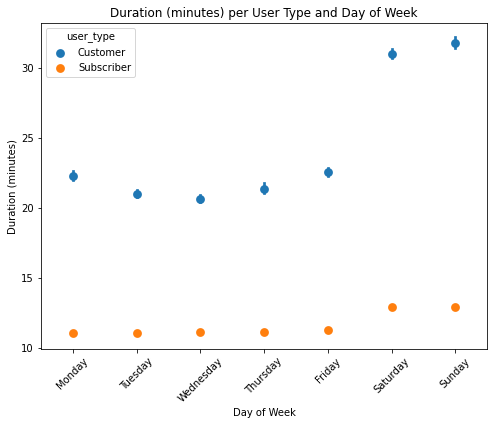

In [238]:
%%time
plt.figure(figsize=[8, 6])

sns.pointplot(data = df_minutes, 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Duration (minutes) per User Type and Day of Week');

Wall time: 4min 10s


Text(0.5, 1.0, 'Duration (minutes) per User Type and Day of Week')

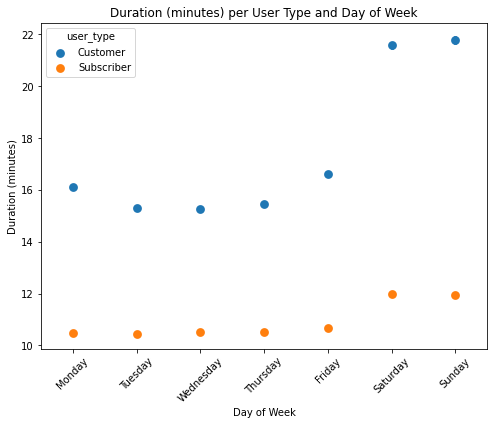

In [239]:
%%time
plt.figure(figsize=[8, 6])

sns.pointplot(data = df_minutes.loc[df_minutes.duration_min <= 120], 
              x = 'start_day_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Duration (minutes)')
plt.title('Duration (minutes) per User Type and Day of Week');

Wall time: 2min 46s


Text(0.5, 1.0, 'Duration (minutes) per User Type and Month')

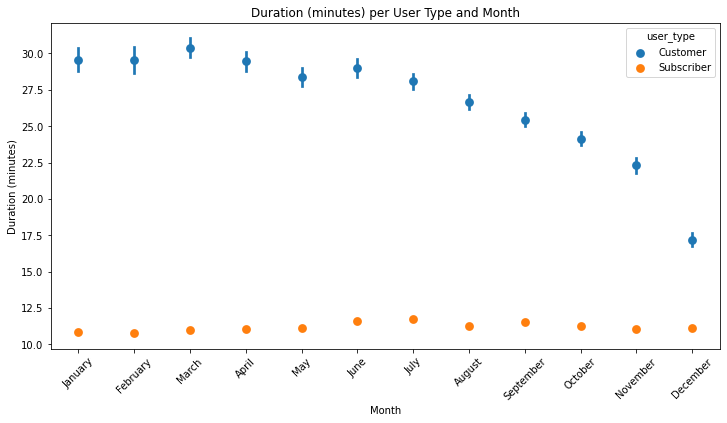

In [240]:
%%time
plt.figure(figsize=[12, 6])

sns.pointplot(data = df_minutes.loc[(df_minutes.yearmonth > '201712') & (df_minutes.yearmonth < '202001')], 
              x = 'start_month_name', y = 'duration_min', hue = 'user_type',
            linestyles = "")
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Duration (minutes)')
plt.title('Duration (minutes) per User Type and Month');